<a href="https://colab.research.google.com/github/Ananassio/Data-Science_lab/blob/main/Project/Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# **Data Science Projekt SS22**
## Estellen eines Recommender System für einen online shop für die RecSys Challenge 2022


Erstellt von: Marius Zimmermann (184756)

Team: /



---

Bei der RecSys Challenge 2022 geht es im wesentlichen darum, anhand von Session Daten vorherzusagen, welcher Artikel am Ende der Session gekauft wird. Die Session Daten beinhalten dabei die Artikel, welche wärend einer Session angesehen wurde. Am Ende jeder Session wird jeweils ein Artikel gekauft (siehe Abbildung).



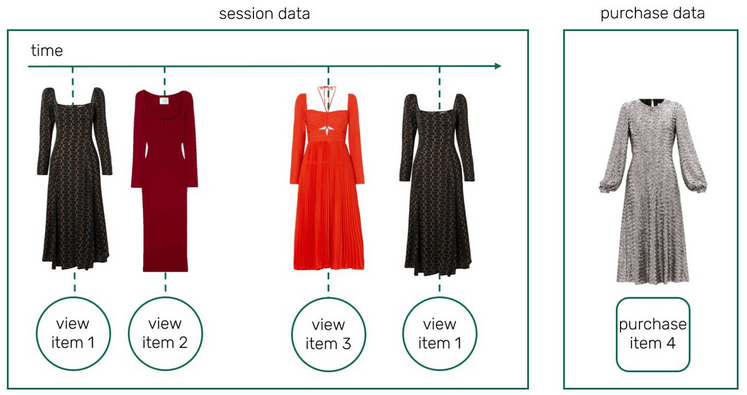

Quelle: http://www.recsyschallenge.com/2022/index.html#about


# Importieren der Daten
Hier werden alle benötigten Daten und Bibiliotheken eingebunden.

In [ ]:
#get data from server
!wget --no-check-certificate https://www.keuper-labs.org/project_ss22.zip

--2022-06-25 13:55:08--  https://www.keuper-labs.org/project_ss22.zip
Resolving www.keuper-labs.org (www.keuper-labs.org)... 91.250.118.129
Connecting to www.keuper-labs.org (www.keuper-labs.org)|91.250.118.129|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 70859177 (68M) [application/zip]
Saving to: ‘project_ss22.zip.1’

project_ss22.zip.1  100%[===================>]  67.58M  11.4MB/s    in 6.4s    

2022-06-25 13:55:15 (10.5 MB/s) - ‘project_ss22.zip.1’ saved [70859177/70859177]



In [ ]:
#unpack
!unzip project_ss22.zip 

Archive:  project_ss22.zip
replace dressipi_recsys2022/candidate_items.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# install 
!pip install scikit-optimize


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#install DASK
!pip install distributed "dask[complete]" dask-ml graphviz  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import some libarys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics import accuracy_score,log_loss
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.layers.experimental.preprocessing import Normalization
#from tensorflow.keras import layers
from sklearn.preprocessing import normalize

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import mean_absolute_error


from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn import datasets
from numpy import count_nonzero



from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

from dask.distributed import Client
import joblib
from xgboost import XGBClassifier,XGBRegressor
#from dask_ml.xgboost import XGBClassifier


#from skopt import BayesSearchCV
#from skopt.space import Real, Categorical, Integer
#from sklearn.metrics import mean_squared_error

In [ ]:
# asign the Data to variables
items = pd.read_csv('dressipi_recsys2022/candidate_items.csv')
features = pd.read_csv('dressipi_recsys2022/item_features.csv')
train_purchases = pd.read_csv('dressipi_recsys2022/train_purchases.csv')
train_sessions = pd.read_csv('dressipi_recsys2022/train_sessions.csv')
test_leaderboard_sessions = pd.read_csv('dressipi_recsys2022/test_leaderboard_sessions.csv')
test_final_sessions = pd.read_csv('dressipi_recsys2022/test_final_sessions.csv')

## Blick auf die Daten
Hier werden zunächst die Datensätze einmal ausgegeben, um einen Überblick 
zubekommen wie diese aufgebaut sind.



---




In dem items Datensatz sind die item ids, welche in bei den testsessions gekauft wurden 

In [ ]:
items

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


In [ ]:
#how many items do we have?
items.describe()

,item_id
count,4990.000000
mean,14007.035271
std,8218.231425
min,4.000000
25%,6833.500000
50%,14108.500000
75%,21200.000000
max,28137.000000




---


In dem features Dataset sind die entsprechenden item features der jeweiligen items aufgelistet. Dabei werden die feature Kategorien wie Farbe, Ausschnitt, etc mit einer value id z.B. grün beschrieben. Die einzelnen items haben mehrere Kategorien, welche die items beschreiben, siehe hier z.B. item 2 hat 13 feature Kategorien.

In [ ]:
features

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


In [ ]:
features.describe()

,item_id,feature_category_id,feature_value_id
count,471751.000000,471751.000000,471751.000000
mean,14058.539477,42.424597,486.345578
std,8107.465455,22.186285,258.865151
min,2.000000,1.000000,1.000000
25%,7060.000000,25.000000,273.000000
50%,14045.000000,47.000000,512.000000
75%,21063.000000,61.000000,708.000000
max,28143.000000,73.000000,905.000000




---


Der Train_purchases Datensatz beinhaltet eine item id, welche am Ende der jeweiligen session letzlich gekauft wurde. Zusätzlich gibt es dabei noch einen Zeitstempel.
Die gesamten Daten wurden in einem Zeitraum von 18 Monaten aufgezeichnet, dabei wurden Daten der ersten 17 Monate für den Trainingsdatensatz verwendet und der letzte Monat wurde für den Testdatensatz verwendet.

In [ ]:
train_purchases

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356




---


In dem Datensatz train_session sind die item ids aufgelistet, welche innerhalb einer session angesehen wurden. Auch hier gibt es jeweils einen Zeitstempel.

In [ ]:
train_sessions

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186




---


Auf den Daten des Datensatzes test_leaderboard_session sollen die Vorhersagen für die Bestenliste des Wettbewerbs getätigt werden. 

In [ ]:
test_leaderboard_sessions

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# Datenanalyse
Hier soll ein überblick geschaffen werden, wie die Daten verteilt sind

## Anzahl der angesehenen Items pro Kauf
hier wird gezeigt wie viele Items vor einem Kauf angesehen wurden.


In [ ]:
# first count the ammount of viewed items per session
viewed_items = pd.DataFrame(train_sessions['session_id'].value_counts().sort_values())['session_id'].value_counts()

In [ ]:
viewed_items.to_frame()

,session_id
1,307698
2,174775
3,115499
4,82306
5,60695
...,...
100,6
91,6
98,5
99,5


In [ ]:
# lets use the describe function for better analysing of the numbers 
train_sessions['session_id'].value_counts().sort_values().describe()

count    1000000.000000
mean           4.743820
std            6.084665
min            1.000000
25%            1.000000
50%            3.000000
75%            6.000000
max          100.000000
Name: session_id, dtype: float64

In diesem Plot ist die Anzahl der Sessions für einen kauf dargestellt. Dabei liegt der Mittlewert für die angesehenen Items pro Session bei 4.743820.

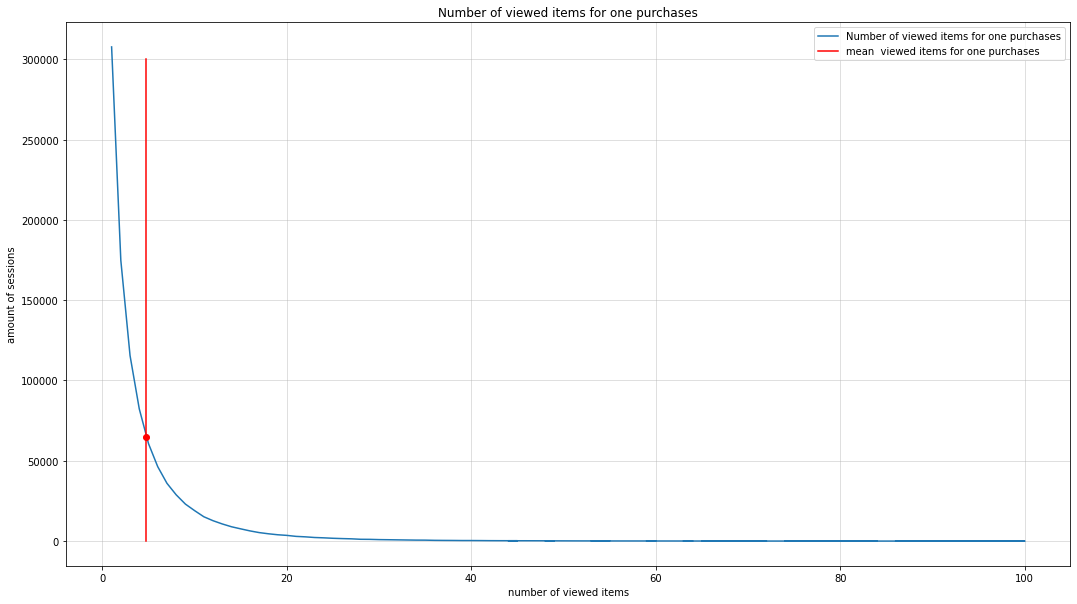

In [ ]:
# print the generated curve of the session ammounts
fig, axes = plt.subplots(figsize=(18,10))

axes.plot(viewed_items,label='Number of viewed items for one purchases')
#plot the mean session
axes.plot([4.743820,4.743820], [0,300000], '-r', label='mean  viewed items for one purchases')
axes.plot(4.743820,65000, 'ro')
#set the labeling
axes.set_xlabel('number of viewed items')
axes.set_ylabel('amount of sessions')
axes.set_title('Number of viewed items for one purchases');
axes.grid(alpha=0.5)
axes.legend()

## Verteilung der Käufe
Als nächsten Schritt wird geschaut an welchen Tagen, zu welchen Uhrzeiten und in welchem Monat die Items gekauft werden.


In [ ]:
# look at the train_purchases Dataset
# label the purchases 
t_purchase_times = pd.DataFrame();
#day
t_purchase_times['day']=pd.to_datetime(train_sessions['date']).dt.day_name()
#month
t_purchase_times['month']=pd.to_datetime(train_sessions['date']).dt.month_name()
#year
t_purchase_times['year']=pd.to_datetime(train_sessions['date']).dt.year
#daytime
t_purchase_times['part_of_day'] = (pd.to_datetime(train_sessions['date']).dt.hour % 24 + 4) // 4
t_purchase_times['part_of_day'].replace({1: 'Late Night', # 0-4 Uhr
                      2: 'Early Morning',                 # 4-8 Uhr
                      3: 'Morning',                       # 8-12 Uhr
                      4: 'Noon',                          # 12-16 Uhr
                      5: 'Evening',                       # 16-20 Uhr
                      6: 'Night'}, inplace=True)          # 20-0 Uhr
t_purchase_times

,day,month,year,part_of_day
0,Friday,December,2020,Night
1,Friday,December,2020,Night
2,Friday,March,2020,Evening
3,Wednesday,August,2020,Evening
4,Wednesday,August,2020,Evening
...,...,...,...,...
4743815,Friday,October,2020,Night
4743816,Friday,October,2020,Night
4743817,Friday,October,2020,Night
4743818,Friday,October,2020,Night


In [ ]:
#how many items where bought in each year
t_purchase_times['year'].value_counts()

2020    3197810
2021    1546010
Name: year, dtype: int64

Werden die Käufe auf die Wochentage verteilt, lässt sich erkennen, dass die meisten Käufe am Wochenende getätigt werden und die wenigsten in der Mitte der Woche.

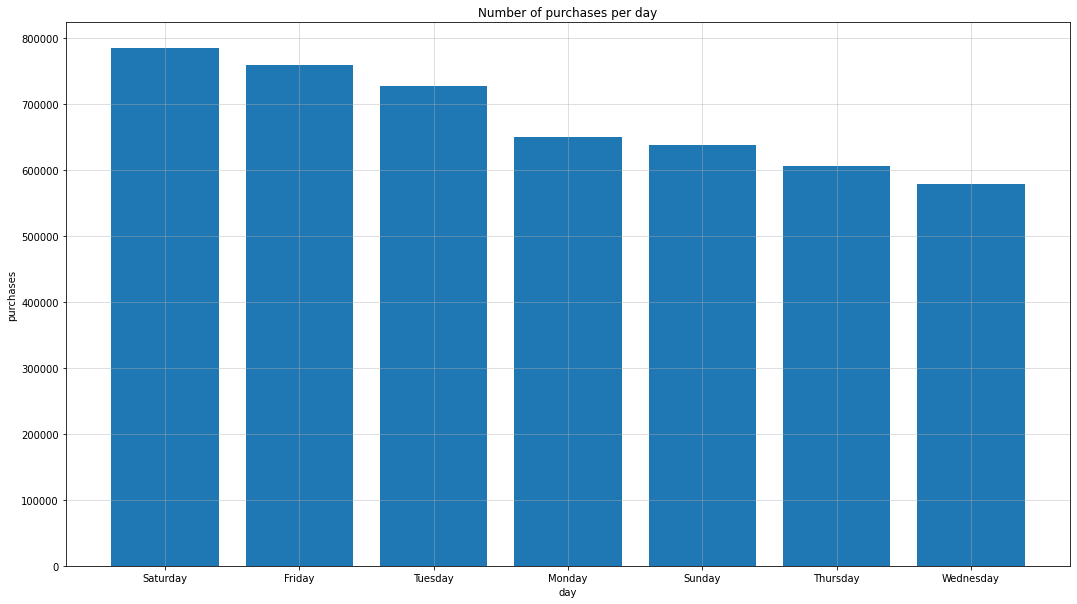

In [ ]:
# print the number of purchases per day
fig, axes = plt.subplots(figsize=(18,10))

axes.bar(t_purchase_times['day'].value_counts().index,t_purchase_times['day'].value_counts())
#set the labeling
axes.set_xlabel('day')
axes.set_ylabel('purchases')
axes.set_title('Number of purchases per day');
axes.grid(alpha=0.5)

Über ein Jahr verteilt sind die meisten Käufe gegen Ende des Jahres, ein Grund hierfür könnten die Weihnachtseinkäufe sein. 

Auffällig ist außerdem, dass im Jahr 2021 jeden Monat die Käufe des jahres 2020 übertroffen wurden. Ein Grund hierfür könnten die Lockdown Maßnahmen sein, welche wegen der Corona-Pandemie ab November 2020 beschlossen wurden.

Da die Trainingsdaten nur über einen Zeitraum von 17 Monaten aufgezeichhnet wurden gibt es für das Jahr 2021 nur für die ersten fünf Monate Daten. 



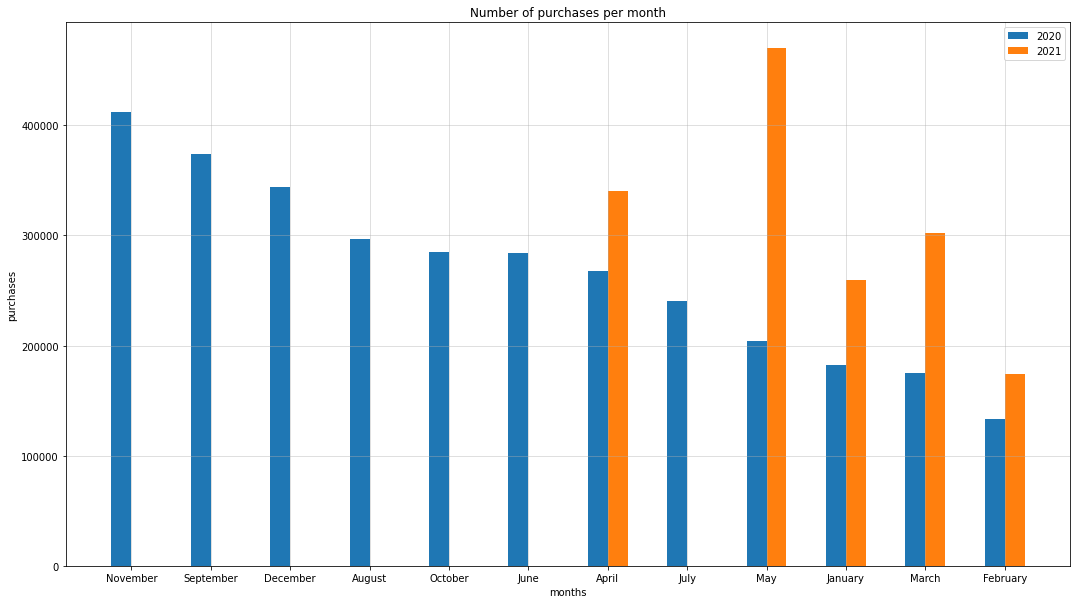

In [ ]:
# print the number of purchases per month
fig, axes = plt.subplots(figsize=(18,10))

axes.bar(t_purchase_times[t_purchase_times['year']==2020]['month'].value_counts().index,t_purchase_times[t_purchase_times['year']==2020]['month'].value_counts(),align='edge', width=-0.25,label='2020')
axes.bar(t_purchase_times[t_purchase_times['year']==2021]['month'].value_counts().index,t_purchase_times[t_purchase_times['year']==2021]['month'].value_counts(),align='edge', width=0.25,label='2021')
#set the labeling
axes.set_xlabel('months')
axes.set_ylabel('purchases')
axes.set_title('Number of purchases per month');
axes.grid(alpha=0.5)
axes.legend(loc=1);

Ein Blick auf die Verteilung der Käufe über einen Tag zeigen, dass mit abstand die wenigsten Käufe zwischen "late night" (0-4 Uhr) und "early morning" (4-8 Uhr) getätigt werden. Die restlichen Käufe wiederum teilen sich auf den verbleibenden Tage auf, wobei dabei die meisten im "evening" (16-20 Uhr) getätigt werden.

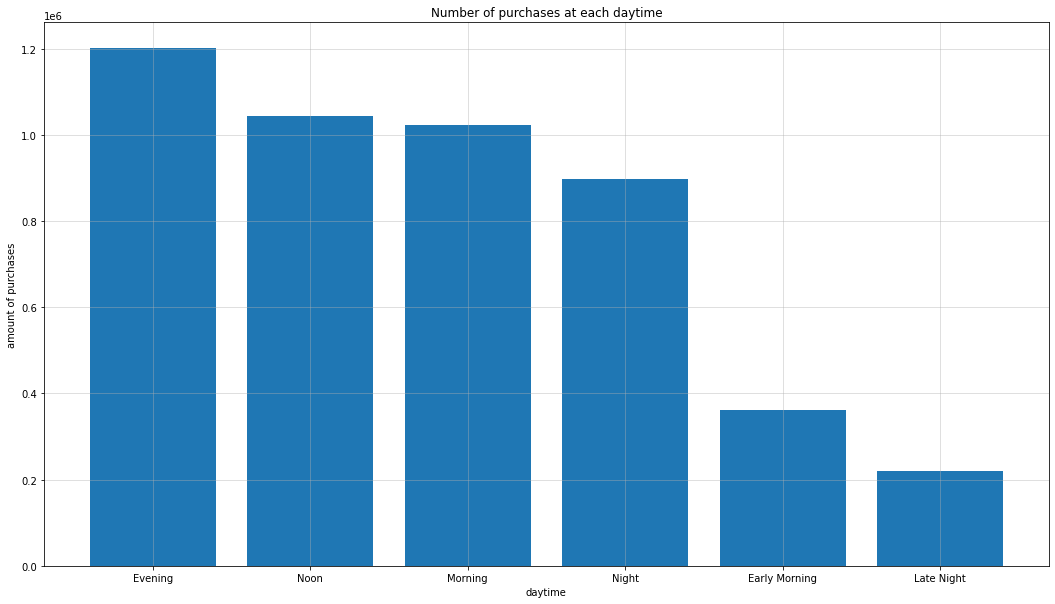

In [ ]:
# print the number of purchases per daytime
fig, axes = plt.subplots(figsize=(18,10))

axes.bar(t_purchase_times['part_of_day'].value_counts().index,t_purchase_times['part_of_day'].value_counts())
#set the labeling
axes.set_xlabel('daytime')
axes.set_ylabel('amount of purchases')
axes.set_title('Number of purchases at each daytime');
axes.grid(alpha=0.5)

## Welche Items wurden oft gekauft

Hier wird angesehen wie oft welches Item gekauft wurde. Also ob es bestimmte Items gibt die besonders oft gekauft werden.

Im Durchschnit wird ein item ~53 mal gekauft und das am häufigsten verkaufte item wurde 8451 mal verkauft.

In [ ]:
train_purchases['item_id'].value_counts()

8060     8451
26853    3829
19882    3355
8622     2745
2447     2726
         ... 
20141       1
24646       1
1581        1
14660       1
3302        1
Name: item_id, Length: 18907, dtype: int64

In [ ]:
train_purchases['item_id'].value_counts().describe()

count    18907.000000
mean        52.890464
std        126.716155
min          1.000000
25%          7.000000
50%         26.000000
75%         61.000000
max       8451.000000
Name: item_id, dtype: float64

werden die anzahl der Käufe pro item ausgegeben, sind einige Ausreißer, welche deutlich öfter gekauft wurden als z.B. der Durchschnitt.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


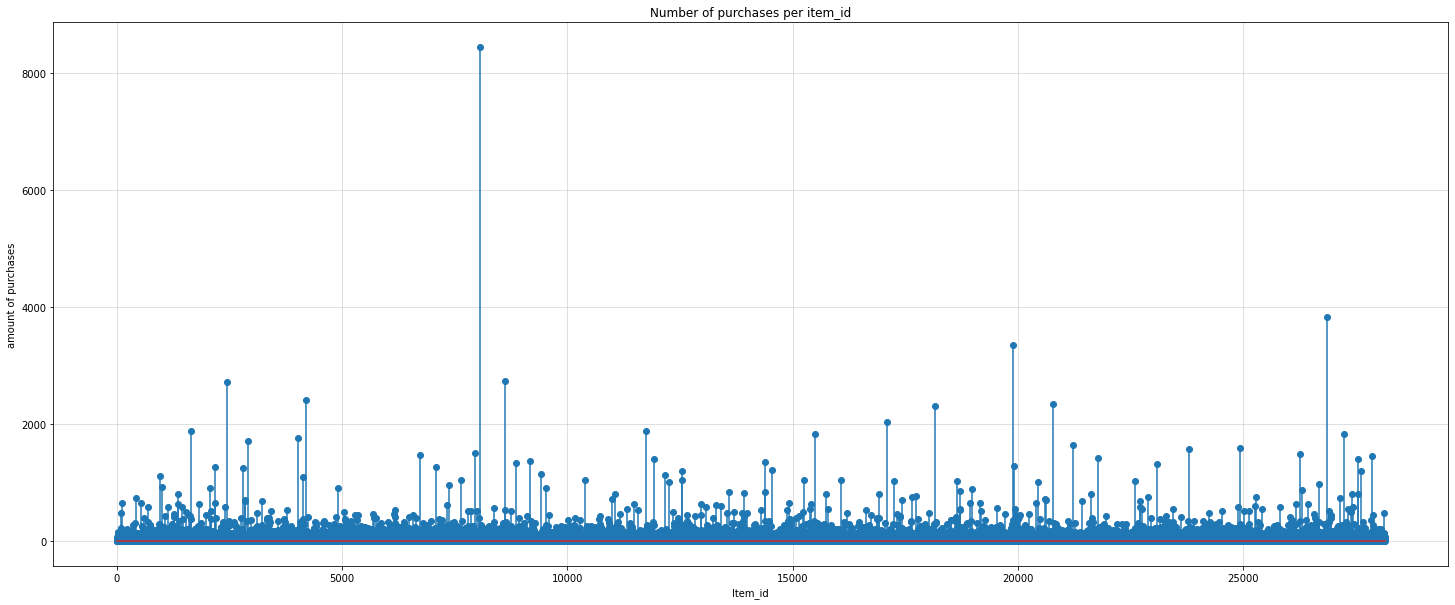

In [ ]:
# print the Number of purchases per item_id
fig, axes = plt.subplots(figsize=(25,10))

axes.stem(train_purchases['item_id'].value_counts().index, train_purchases['item_id'].value_counts())
#set the labeling
axes.set_xlabel('Item_id')
axes.set_ylabel('amount of purchases')
axes.set_title('Number of purchases per item_id');
axes.grid(alpha=0.5)

Ebenfalls deutlich wird dies bei der Ausgabe eines Boxplottes.

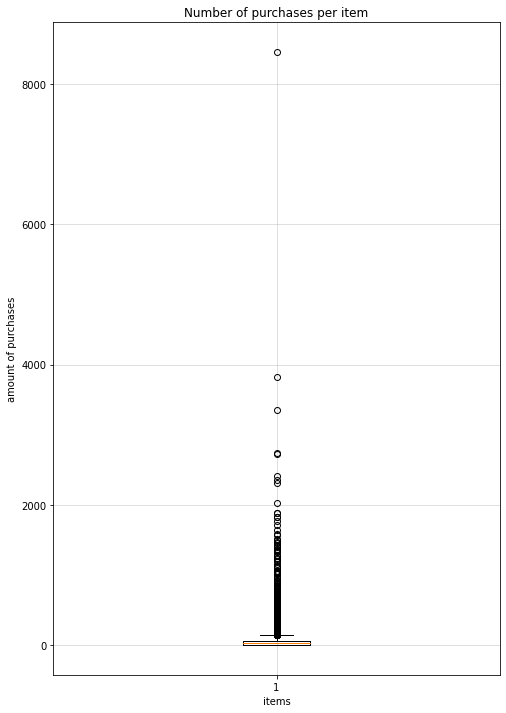

In [ ]:
fig, axes = plt.subplots(figsize=(8,12))
#plot the boxplot of the number of purchases
axes.boxplot(train_purchases['item_id'].value_counts())
#set the labeling
axes.set_xlabel('items')
axes.set_ylabel('amount of purchases')
axes.set_title('Number of purchases per item');
axes.grid(alpha=0.5)

Ein Histogramm der letzen 18500 von den 18907 items zeigt, dass die meisten items unter 100 mal gekauft wurden. (zur besseren Darstellung wurden hier die letzten 407 Items entfernt, da diese besonders oft gekauft wurden und so das Histogramm nicht mehr "gut" darstellbar ist).

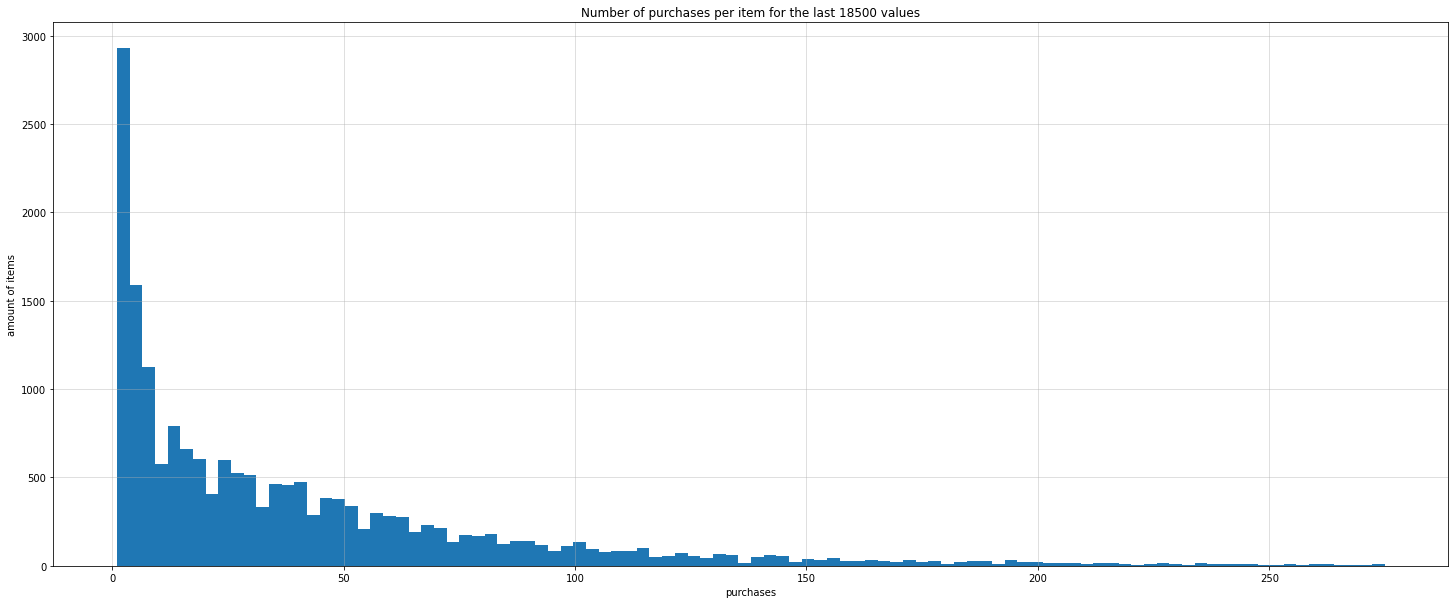

In [ ]:
fig, axes = plt.subplots(figsize=(25,10))
#plot the histogram of the number of purchases for the last 18500 Items
axes.hist(train_purchases['item_id'].value_counts().tail(18500), bins=100)
#set the labeling
axes.set_xlabel('purchases')
axes.set_ylabel('amount of items')
axes.set_title('Number of purchases per item for the last 18500 values');
axes.grid(alpha=0.5)

## Meistgekauften Items
in diesem Abschnitt wird anschaut wie die meist verkauften Items im Bezug auf die gesamten Verkäufe verteilt sind.

Interesant ist hier, dass von den 18907 items

*   die  500 meistverkaufte items (2,64 % der verkauften items) über 25 % der Gesamtverkäufe
*   die  900 meistverkaufte items (4,76 % der verkauften items) über 33 % der Gesamtverkäufe
*   die 2500 meistverkaufte items (13,22 % der verkauften items) über 50 % der Gesamtverkäufe
*   die 5500 meistverkaufte items (29,02 % der verkauften items) über 75 % der Gesamtverkäufe
*   die 9454 meistverkaufte items (50,00 % der verkauften items) über 90 % der Gesamtverkäufe

ausmachen.



In [ ]:
#purchased items
print('all in all there were',train_purchases['item_id'].value_counts().sum(), 'items sold.')

all in all there were 1000000 items sold.


the 500 most sold items ( 2.64 % of the sold items) make 262909 sales. So they make over one quater of the total sales.( 26.29 %)



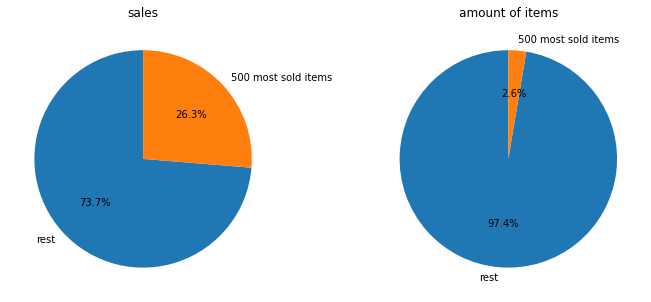

In [ ]:
#purchases of the 500 most sold items
print('the 500 most sold items (',round(500/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(500).sum(), 
      'sales. So they make over one quater of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(500).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '500 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(500).sum(),
         train_purchases['item_id'].value_counts().head(500).sum()]
sizes2 = [ (18907-500)/18907,500/18907]

#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

the 900 most sold items ( 4.76 % of the sold items) make 344324 sales. So they make over one third of the total sales.( 34.43 %)



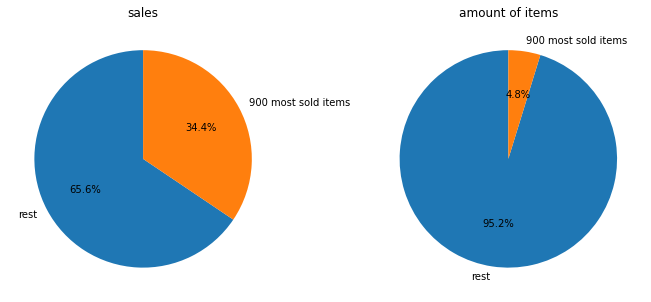

In [ ]:
#purchases of the 900 most sold items
print('the 900 most sold items (',round(900/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(900).sum(), 
      'sales. So they make over one third of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(900).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '900 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(900).sum(),
         train_purchases['item_id'].value_counts().head(900).sum()]
sizes2 = [ (18907-900)/18907,900/18907]

#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

the 2500 most sold items ( 13.22 % of the sold items) make 545255 sales. So they make over the half of the total sales.( 54.53 %)



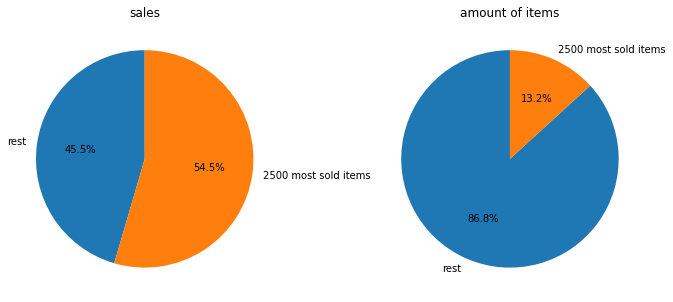

In [ ]:
#purchases of the 2500 most sold items
print('the 2500 most sold items (',round(2500/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(2500).sum(), 
      'sales. So they make over the half of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(2500).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '2500 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(2500).sum(),
         train_purchases['item_id'].value_counts().head(2500).sum()]
sizes2 = [ (18907-2500)/18907,2500/18907]

#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

the 5500 most sold items ( 29.09 % of the sold items) make 758659 sales. So they make over three quaters of the total sales.( 75.87 %)



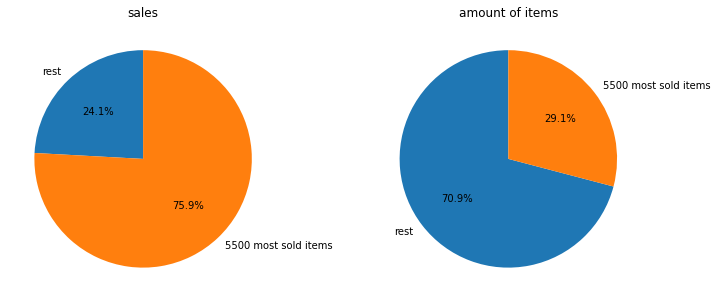

In [ ]:
#purchases of the 5500 most sold items
print('the 5500 most sold items (',round(5500/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(5500).sum(), 
      'sales. So they make over three quaters of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(5500).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '5500 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(5500).sum(),
         train_purchases['item_id'].value_counts().head(5500).sum()]
sizes2 = [ (18907-5500)/18907,5500/18907]
#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

the 9454 most sold items ( 50.0 % of the sold items) make 912344 sales. So they make over 90 % of the total sales.( 91.23 %)



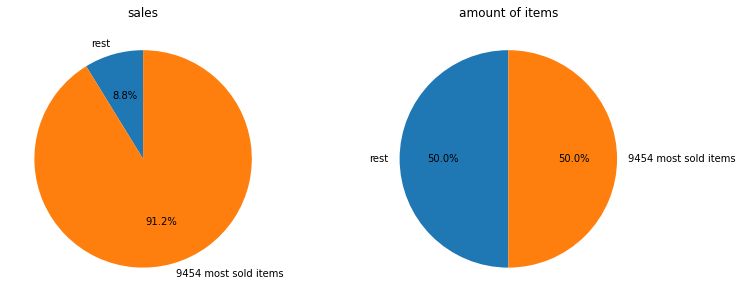

In [ ]:
#purchases of the 9454 most sold items
print('the 9454 most sold items (',round(9454/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(9454).sum(), 
      'sales. So they make over 90 % of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(9454).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '9454 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(9454).sum(),
         train_purchases['item_id'].value_counts().head(9454).sum()]
sizes2 = [ (18907-9454)/18907,9454/18907]
#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

# Data Wrangling

Um die features nutzbar zu machen, soll der Datensatz in einer Tabelle mit der item_id als index und die feature_category_ids als spalten dargestellt werde.
Allerdings gibt es in dem features Dataframe doppelte Einträge, wodurch die pivot funktion nicht direkt angewendet werden kann. 
(Damit der code an einem Stück durchlaufen kann, wurde hierfür ein Screenshot der Fehlermelung eingefügt)
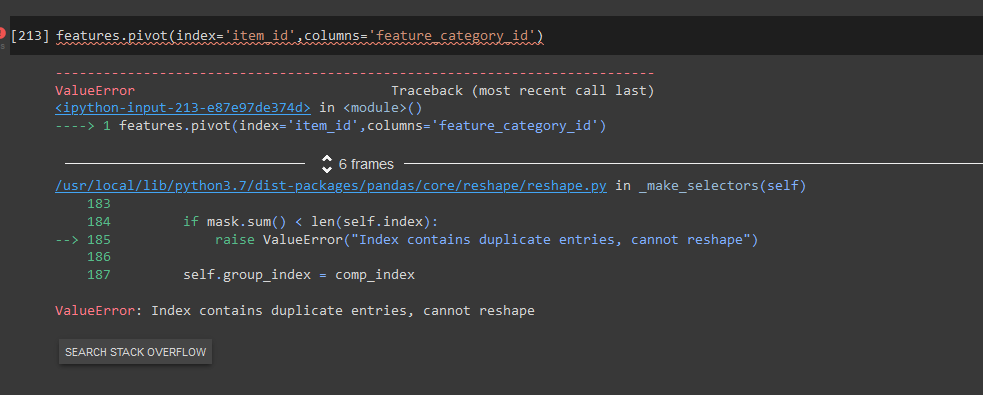

## Finden der doppelten feature_category_ids

In [ ]:
#search for the duplicated feature_ids in the features DataFrame
# first drop the feature_value_id so that the duplicated feature_ids can be found
a = features.drop(['feature_value_id'],axis=1)
doub_cats = [0]*6;
j = 0;
for i in a['feature_category_id'].unique():
  if a[a['feature_category_id']== i].duplicated().sum() > 0:
    doub_cats[j] = i;
    j= j+1;
print('the duplicadet feature_category_ids are:');
doub_cats

the duplicadet feature_category_ids are:


[53, 46, 4, 30, 28, 1]

In [ ]:
 #check if the duplicates are correct
 features[features['feature_category_id'] == 30]

,item_id,feature_category_id,feature_value_id
129,10,30,564
134,10,30,482
153,11,30,847
154,11,30,478
156,11,30,715
...,...,...,...
471557,28133,30,482
471561,28133,30,194
471590,28135,30,564
471593,28135,30,478


In [ ]:
#print in witch feature_value_ids have the feature_category_id 30 
vals_id30 = features[features['feature_category_id'] == 30]['feature_value_id'].unique()
vals_id30.sort()
vals_id30

array([ 37,  42,  48,  62, 107, 118, 127, 136, 141, 150, 154, 173, 194,
       203, 228, 235, 259, 271, 285, 291, 325, 360, 375, 377, 391, 392,
       413, 417, 419, 426, 435, 453, 466, 478, 482, 493, 497, 532, 562,
       564, 582, 613, 638, 640, 641, 648, 654, 661, 669, 670, 715, 721,
       775, 790, 807, 809, 820, 827, 832, 835, 847, 867, 869, 880, 891,
       892, 900])

Ausgeben wie häufig die feature_category_ids mehrfach belegt sind.   

In [ ]:
for i in doub_cats:
  print('There are max',features[features['feature_category_id'] == i]['item_id'].value_counts().max(), 'times the feature_category_id', i, ' in one item')

There are max 2 times the feature_category_id 53  in one item
There are max 2 times the feature_category_id 46  in one item
There are max 4 times the feature_category_id 4  in one item
There are max 8 times the feature_category_id 30  in one item
There are max 3 times the feature_category_id 28  in one item
There are max 2 times the feature_category_id 1  in one item


Ausgeben wie viele verschiedene feature_value_ids die feature_category_ids haben

In [ ]:
for i in doub_cats:
  print('There are ',features[features['feature_category_id'] == i]['feature_value_id'].nunique(), 'different values in the feature_category_id', i, )



There are  5 different values in the feature_category_id 53
There are  4 different values in the feature_category_id 46
There are  16 different values in the feature_category_id 4
There are  67 different values in the feature_category_id 30
There are  6 different values in the feature_category_id 28
There are  6 different values in the feature_category_id 1


Um die feature_value_ids der feature_category_id 30 binär eindeutig zu codieren würden 8 * 1 Byte benötig. nachfolgen ein Beispiel wie dies aussehen könnte.

In [ ]:
bin(1<<(7*8)| 10<<(6*8) | 15<< (5*8) | 28 << (4*8) | 32 << (3*8) | 45 << (2*8) | 50 << (1*8) | 67<<(0*8))

'0b100001010000011110001110000100000001011010011001001000011'

## Umgangs Möglichkeiten mit den doppelten Einträgen
Es gibt verschiedene Möglichkeiten wie mit den doppelten Einträgen umgegangen werden kann. Hier werden drei Möglichkeiten aufgeführt. Aufgrund der begrenzten Zeit und des Aufwandes wurde sich für die zweite Möglichkeit "pivot_table Funktion verwenden" entschieden.

### Doppelte Einträge löschen

Eine Möglickeit besteht darin die feature_category_ids mit dopelten Einträgen zu löschen

In [ ]:
#first drop the duplicated to check if now no mare duplicates are here
droped = features.drop(features[features['feature_category_id'] == 30].index)
droped = droped.drop(droped[droped['feature_category_id'] == 53].index)
droped = droped.drop(droped[droped['feature_category_id'] == 46].index)
droped = droped.drop(droped[droped['feature_category_id'] == 4].index)
droped = droped.drop(droped[droped['feature_category_id'] == 28].index)
droped = droped.drop(droped[droped['feature_category_id'] == 1].index)

Mit dem entfernen der feature_value_ids mit doppeltem vorkommen lässt sich nun die pivot function anwenden. Allerdings könnten so wichtige Eigenschaften, wie z.B. die Farben der Items nicht berücksichtigt sein. Deshalb wird diese Möglichkeit nicht in Betracht gezogen.

In [ ]:
#now the pivot function works, but 6 feature_category_ids are dropped
droped.pivot(index='item_id',columns='feature_category_id')

feature_value_id                                       \
feature_category_id               2      3      5   6      7   8   9   10   
item_id                                                                     
2                                NaN    NaN    NaN NaN  394.0 NaN NaN NaN   
3                                NaN  889.0  605.0 NaN  452.0 NaN NaN NaN   
4                                NaN  793.0  605.0 NaN  837.0 NaN NaN NaN   
7                                NaN    NaN    NaN NaN  536.0 NaN NaN NaN   
8                                NaN  793.0  605.0 NaN  798.0 NaN NaN NaN   
...                              ...    ...    ...  ..    ...  ..  ..  ..   
28139                            NaN  793.0  605.0 NaN  798.0 NaN NaN NaN   
28140                           53.0    NaN    NaN NaN    NaN NaN NaN NaN   
28141                            NaN  889.0  605.0 NaN    2.0 NaN NaN NaN   
28142                            NaN    NaN    NaN NaN  619.0 NaN NaN NaN   
28143                            NaN    NaN    NaN NaN  798.0 NaN NaN NaN   

                                ...                                            \
feature_category_id     11  12  ...    64     65  66     67     68     69  70   
item_id                         ...                                             
2                      NaN NaN  ...   NaN    NaN NaN    NaN  351.0  885.0 NaN   
3                    859.0 NaN  ...   NaN  521.0 NaN    NaN   14.0  592.0 NaN   
4                      NaN NaN  ...   NaN  521.0 NaN    NaN  373.0  538.0 NaN   
7                      NaN NaN  ...   NaN    NaN NaN    NaN  739.0  592.0 NaN   
8                    735.0 NaN  ...   NaN  521.0 NaN    NaN  351.0  592.0 NaN   
...                    ...  ..  ...   ...    ...  ..    ...    ...    ...  ..   
28139                  NaN NaN  ...   NaN  521.0 NaN    NaN  106.0  805.0 NaN   
28140                  NaN NaN  ...  80.0    NaN NaN  349.0  351.0    NaN NaN   
28141                  NaN NaN  ...   NaN    NaN NaN    NaN  379.0  499.0 NaN   
28142                  NaN NaN  ...   NaN  610.0 NaN    NaN  895.0  740.0 NaN   
28143                109.0 NaN  ...   NaN    NaN NaN    NaN  351.0  499.0 NaN   

                                          
feature_category_id     71     72     73  
item_id                                   
2                      NaN   75.0    NaN  
3                      NaN   75.0  544.0  
4                      NaN   75.0  544.0  
7                      NaN   75.0    NaN  
8                      NaN   75.0  544.0  
...                    ...    ...    ...  
28139                  NaN   75.0  544.0  
28140                226.0    NaN  544.0  
28141                  NaN   75.0  544.0  
28142                  NaN   75.0   91.0  
28143                  NaN  371.0   91.0  

[23691 rows x 67 columns]

### pivot_table Funktion verwenden

Eine andere Möglichkeit wäre die Funktion pivot_table, hier werden allerdings die doppelten Werte z.B. auf summiert oder deren Mittelwert gebildet, was auch zu einer verfälschung der Werte führt. Damit wären keine logischen zusammenhänge mehr möglich.
Wird jeweils der minimale oder maximale Wert verwendet gehen Daten verloren, aber es würde zumindest ein unrsprünglicher Wert erhaltenbleiben. Dieser Ansatz wird in dem Projekt weiter verfolgt.

In [ ]:
feature_pivtable = features.pivot_table(index='item_id',columns='feature_category_id',  fill_value=0,aggfunc='min')
feature_pivtable

feature_value_id                                      ...  \
feature_category_id               1   2    3    4    5  6    7  8  9  10  ...   
item_id                                                                   ...   
2                                  0   0    0    0    0  0  394  0  0  0  ...   
3                                  0   0  889  618  605  0  452  0  0  0  ...   
4                                  0   0  793  618  605  0  837  0  0  0  ...   
7                                  0   0    0    0    0  0  536  0  0  0  ...   
8                                  0   0  793  618  605  0  798  0  0  0  ...   
...                              ...  ..  ...  ...  ... ..  ... .. .. ..  ...   
28139                              0   0  793  618  605  0  798  0  0  0  ...   
28140                              0  53    0    0    0  0    0  0  0  0  ...   
28141                            461   0  889  719  605  0    2  0  0  0  ...   
28142                              0   0    0    0    0  0  619  0  0  0  ...   
28143                              0   0    0    0    0  0  798  0  0  0  ...   

                                                                  
feature_category_id  64   65 66   67   68   69 70   71   72   73  
item_id                                                           
2                     0    0  0    0  351  885  0    0   75    0  
3                     0  521  0    0   14  592  0    0   75  544  
4                     0  521  0    0  373  538  0    0   75  544  
7                     0    0  0    0  739  592  0    0   75    0  
8                     0  521  0    0  351  592  0    0   75  544  
...                  ..  ... ..  ...  ...  ... ..  ...  ...  ...  
28139                 0  521  0    0  106  805  0    0   75  544  
28140                80    0  0  349  351    0  0  226    0  544  
28141                 0    0  0    0  379  499  0    0   75  544  
28142                 0  610  0    0  895  740  0    0   75   91  
28143                 0    0  0    0  351  499  0    0  371   91  

[23691 rows x 73 columns]

Wie hier zusehen ist diese Matrix sparse, da auf die 73 feature_value_ids im durchschnittt nur rund 20 Werte kommen.

In [ ]:
feature_pivtable.transpose().nunique().mean()

20.41817567852771

### Doppelte Einträge zusammenfassen

Eine dritte Möglichkeit besteht darin die doppelten Einträge zu codieren z.B. binär.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

In [ ]:
e = enc.fit_transform(features)

In [ ]:
pd.DataFrame(e)

,0
0,"(0, 0)\t1.0\n (0, 23746)\t1.0\n (0, 24123)..."
1,"(0, 0)\t1.0\n (0, 23752)\t1.0\n (0, 24552)..."
2,"(0, 0)\t1.0\n (0, 23758)\t1.0\n (0, 24109)..."
3,"(0, 0)\t1.0\n (0, 23723)\t1.0\n (0, 24553)..."
4,"(0, 0)\t1.0\n (0, 23762)\t1.0\n (0, 23837)..."
...,...
471746,"(0, 23690)\t1.0\n (0, 23758)\t1.0\n (0, 24..."
471747,"(0, 23690)\t1.0\n (0, 23745)\t1.0\n (0, 24..."
471748,"(0, 23690)\t1.0\n (0, 23701)\t1.0\n (0, 23..."
471749,"(0, 23690)\t1.0\n (0, 23763)\t1.0\n (0, 23..."


In [ ]:
enc.fit_transform(features)

<471751x24654 sparse matrix of type '<class 'numpy.float64'>'
	with 1415253 stored elements in Compressed Sparse Row format>

In [ ]:
pd.get_dummies(features[features['feature_category_id'] == 46]['feature_value_id'])

,71,783,825,882
22,0,0,1,0
49,0,0,1,0
94,0,0,1,0
117,0,0,1,0
202,0,0,1,0
...,...,...,...,...
471501,0,0,1,0
471525,0,1,0,0
471649,0,0,1,0
471661,0,1,0,0


In [ ]:
a = pd.get_dummies(features[features['feature_category_id'] == 30]['feature_value_id'])
a

,37,42,48,62,107,118,127,136,141,150,...,827,832,835,847,867,869,880,891,892,900
129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
471561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
471590,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
471593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
np.packbits(list(a[a.index==129].values[0]),axis=0)

array([0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)

Das hatte allerdings nicht so richtig auf anhieb funktioniert. Deshalb und wegen der begrenzten Zeit wird darauf verzichtet.

# Baseline 
Hier werden zunächst einfache Baseline Ansätze getestet.

## Erstellen eines zufälligen Test scores
Erstellen eines Zufälligen Testscores mit je 100 zufälligen Item ids pro Session. Die item ids werden hierfür aus der items liste entnommen.
Der Score betrug dabei:  0.0010567088232443147 -> ~0,106 %

In [ ]:
#generate a random recomendation of the items out of items
rand_pred = pd.DataFrame();
#use the session ids out of the test_leaderboard_sessions
rand_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
#repeat each session 100 times
rand_pred  = rand_pred.loc[rand_pred.index.repeat(100)].reset_index(drop=True)
#pick randomo item ids
rand_pred['item_id'] = np.random.choice(items['item_id'], size=(len(rand_pred)))
#set the rank from 0 - 100
rand_pred['rank'] = rand_pred.groupby('session_id').cumcount()+1
#set the index to session id
rand_pred = rand_pred.set_index('session_id')

In [ ]:
#plot the random prediction
rand_pred.head()

,item_id,rank
session_id,,
26,15158,1
26,537,2
26,21425,3
26,15081,4
26,7375,5


In [ ]:
#save the random prediction as csv
rand_pred.to_csv('rand_pred.csv')

## Vorschlagen des letzten angesehen item

In diesem Abschnitt wird das zuletzt angesehene Item vorgeschlagen.

Der erreichte Score betrug dabei:  0.0008 -> 0,08 % und ist damit schlechter, als die zufällig vorgeschlagenen Items. Zu beachten ist hier allerdings, dass dabei nur ein item vorgeschlagen wird und bei den zufällig vorgeschlagenen Items werden jeweils 100 Items vorgeschlagen.

In [ ]:
last_item = pd.DataFrame();
#search the index with the last viewed item
idx = test_leaderboard_sessions.groupby(['session_id'])['date'].transform(max) == test_leaderboard_sessions['date']
last_item = test_leaderboard_sessions[idx]
last_item

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
4,200,4758,2021-06-25 12:24:50.692
5,205,8194,2021-06-11 00:28:07.058
6,495,6853,2021-06-14 22:13:06.741
7,521,26471,2021-06-19 13:50:03.09
...,...,...,...
229337,4439446,21396,2021-06-11 17:17:11.565
229339,4439458,26499,2021-06-09 04:54:45.378
229340,4439550,19086,2021-06-02 17:42:40.481
229350,4439653,12179,2021-06-11 10:23:00.663


Wie zu erkennen ist gibt es trotzdem noch 6 doppelte Einträge, vermutlich da bei diesen der Zeitstempel sehr nah beieinander oder identisch ist. Von diesen duplikaten wird das letzte verwendet und das erste gelöscht.

In [ ]:
last_item['session_id'].value_counts().max()

2

In [ ]:
#drop the duplicates
last_item = last_item[~last_item['session_id'].duplicated(keep='last')]

In [ ]:
#check if choosen items are realx the last watched items
test_leaderboard_sessions.head(10)

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
5,205,8194,2021-06-11 00:28:07.058
6,495,6853,2021-06-14 22:13:06.741
7,521,26471,2021-06-19 13:50:03.09
8,587,22204,2021-06-01 16:43:22.80
9,721,13914,2021-06-19 18:46:57.263


In [ ]:
#generate the format for the competition
last_item = last_item.drop(['date'], axis=1)
last_item['rank'] = 1
last_item = last_item.set_index('session_id')

In [ ]:
last_item

,item_id,rank
session_id,,
26,19185,1
200,4758,1
205,8194,1
495,6853,1
521,26471,1
...,...,...
4439446,21396,1
4439458,26499,1
4439550,19086,1


In [ ]:
last_item.to_csv('last_item.csv')

## Vorschlagen zufälliger items aus den X meistgekauften items
Wie in Abschnitt Datenalyse/Welche items wurden oft gekauft/ gezeigt sind die meisten verkäufe auf vergleichsweise wenige items zurückzuführen. Aus diesem Grund werden hier für vier Beispiele zufällige Vorhersagen erstellt. Mit den


*   500 meist verkauften items
*   900 meist verkauften items
*   2500 meist verkauften items
*   9454 meist verkauften items






---

500 meist verkaufte items (Score =   0.0030179652295973616 -> 0,3018 %)

In [ ]:
#write the item its of the 9454 most bought items in the variable MBI9454
MBI500 = train_purchases['item_id'].value_counts().head(500).index
# generate a random prediction with the 500 most bougth items 
mbi500_pred = pd.DataFrame();
mbi500_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
mbi500_pred  = mbi500_pred.loc[mbi500_pred.index.repeat(100)].reset_index(drop=True)
mbi500_pred['item_id'] = np.random.choice(MBI500, size=(len(mbi500_pred)))
mbi500_pred['rank'] = mbi500_pred.groupby('session_id').cumcount()+1
mbi500_pred = mbi500_pred.set_index('session_id')

mbi500_pred.to_csv('mbi500_pred.csv')



---

900 meist verkaufte items (Score = 0,002149192564937604 -> ~0,215 %)

In [ ]:
#write the item its of the 900 most bought items in the variable MBI900
MBI900 = train_purchases['item_id'].value_counts().head(900).index
# generate a random prediction with the 500 most bougth items 
mbi900_pred = pd.DataFrame();
mbi900_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
mbi900_pred  = mbi900_pred.loc[mbi900_pred.index.repeat(100)].reset_index(drop=True)
mbi900_pred['item_id'] = np.random.choice(MBI900, size=(len(mbi900_pred)))
mbi900_pred['rank'] = mbi900_pred.groupby('session_id').cumcount()+1
mbi900_pred = mbi900_pred.set_index('session_id')

mbi900_pred.to_csv('mbi900_pred.csv')



---

2500 meist verkaufte items (Score =  8.35697856586405e-05 -> ~ 0,008357 %)

In [ ]:
#write the item its of the 2500 most bought items in the variable MBI2500
MBI2500 = train_purchases['item_id'].value_counts().head(2500).index
# generate a random prediction with the 2500 most bougth items 
mbi2500_pred = pd.DataFrame();
mbi2500_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
mbi2500_pred  = mbi2500_pred.loc[mbi2500_pred.index.repeat(100)].reset_index(drop=True)
mbi2500_pred['item_id'] = np.random.choice(MBI2500, size=(len(mbi2500_pred)))
mbi2500_pred['rank'] = mbi2500_pred.groupby('session_id').cumcount()+1
mbi2500_pred = mbi2500_pred.set_index('session_id')

mbi2500_pred.to_csv('mbi2500_pred.csv')



---

9454 meist verkaufte items (Score =  0.0004470316405966391 -> 0,0447 %)

In [ ]:
#write the item its of the 9454 most bought items in the variable MBI9454
MBI9454 = train_purchases['item_id'].value_counts().head(9454).index
# generate a random prediction with the 9454 most bougth items 
mbi9454_pred = pd.DataFrame();
mbi9454_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
mbi9454_pred  = mbi9454_pred.loc[mbi9454_pred.index.repeat(100)].reset_index(drop=True)
mbi9454_pred['item_id'] = np.random.choice(MBI9454, size=(len(mbi9454_pred)))
mbi9454_pred['rank'] = mbi9454_pred.groupby('session_id').cumcount()+1
mbi9454_pred = mbi9454_pred.set_index('session_id')

mbi9454_pred.to_csv('mbi9454_pred.csv')

Iinteressant ist hier, dass die letzten beiden Scores schlechter als die komplett zufällig gewählten Items sind. Außerdem fallt der Score der 2500 meist gekauften Items etwas aus der Reihe.

# Kosinusdistanz
In diesem Abschnitt wird die Kosinusdistanz jeder Session zu jedem Item berechnet und die 100 Werte, wechle am nächsten an der Session sind Vorgeschlagen.

## Präparieren der Daten
Zunächst müssen die Daten noch Vorbereitet werden. Dazu wird der Zeitstempel entfernt.

In [ ]:
cos = test_leaderboard_sessions.drop('date', axis= 1)
cos

,session_id,item_id
0,26,19185
1,200,17089
2,200,17089
3,200,8060
4,200,4758
...,...,...
229349,4439653,25955
229350,4439653,12179
229351,4439757,2078
229352,4439757,2078


Als nächstes werden die feature_values zu den Item_ids hinzugefügt. Wenn mehrere Items in einer Session angesehen wurden, werden deren feature_values vektoriell addiert.

In [ ]:
Session_Vectors = cos.set_index('item_id').join(feature_pivtable['feature_value_id'],how='inner')

In [ ]:
# summarize all vectors from one session 
Session_Vectors = Session_Vectors.groupby('session_id').sum()
Session_Vectors

,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
session_id,,,,,,,,,,,,,,,,,,,,,
26,0,0,793,618,605,0,798,0,0,0,...,0,521,0,0,351,805,0,0,75,544
200,0,0,0,2472,0,0,1576,0,0,0,...,0,0,0,0,1159,3540,0,0,300,2176
205,0,0,793,618,58,0,798,0,0,0,...,0,521,0,0,103,780,0,0,371,544
495,0,0,0,618,0,0,452,0,0,0,...,0,454,0,0,383,639,0,0,219,544
521,0,0,793,618,146,0,619,0,0,0,...,0,521,0,0,445,592,0,0,7,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439446,0,0,0,1854,0,0,1182,0,0,0,...,0,0,0,0,1447,2655,0,0,225,1632
4439458,0,0,793,1236,605,0,1238,0,0,0,...,0,1042,0,0,967,1397,0,0,634,1088
4439550,0,0,0,618,0,0,394,0,0,0,...,0,0,0,0,106,805,0,0,75,544


Für einen zweiten Schritt werden hier nur die Items verwendet, welche sich in dem Items Datensatz befinden.

In [ ]:
test2 = items.set_index('item_id').join(feature_pivtable['feature_value_id'],how='inner')
test2

,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
item_id,,,,,,,,,,,,,,,,,,,,,
4,0,0,793,618,605,0,837,0,0,0,...,0,521,0,0,373,538,0,0,75,544
8,0,0,793,618,605,0,798,0,0,0,...,0,521,0,0,351,592,0,0,75,544
9,0,0,793,618,605,0,536,0,0,0,...,0,521,0,0,222,805,0,0,649,544
19,0,0,0,618,0,399,619,0,0,0,...,0,521,0,0,103,592,0,0,75,544
20,461,0,793,618,605,0,837,0,0,0,...,0,0,0,0,31,116,0,0,75,544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28128,0,0,793,618,605,0,2,0,0,0,...,0,521,0,0,745,885,0,0,75,544
28131,0,0,0,618,0,0,490,0,0,0,...,0,521,0,0,767,592,0,0,7,544
28132,0,53,0,0,0,0,0,0,0,0,...,0,0,264,382,659,0,0,0,0,544


## Berechnen der Kosinusdistanz

Zunächst wird eine Hilfsmatrix aufgestellt. In dieser Hilfsmatrix befinden sich die item_features aller Items. 

In [ ]:
#generate the normalized support matrix
w = np.zeros((len(np.array(feature_pivtable)),73))
ii = 0
for i in feature_pivtable.index:
  w[ii] = feature_pivtable[feature_pivtable.index==i]['feature_value_id']
  w[ii] = w[ii]/np.linalg.norm(w[ii])
  ii = ii+1
w = pd.DataFrame(w)
w = w.transpose()
w

,0,1,2,3,4,5,6,7,8,9,...,23681,23682,23683,23684,23685,23686,23687,23688,23689,23690
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.178392,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025925,0.000000,0.000000,0.000000
2,0.000000,0.315523,0.293068,0.000000,0.263263,0.270303,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.275896,0.274488,0.000000,0.344013,0.000000,0.000000
3,0.000000,0.219340,0.228394,0.000000,0.205166,0.210653,0.000000,0.000000,0.302573,0.000000,...,0.292594,0.000000,0.251311,0.284162,0.215011,0.213913,0.000000,0.278229,0.000000,0.000000
4,0.000000,0.214726,0.223589,0.000000,0.200850,0.206221,0.000000,0.000000,0.000000,0.228189,...,0.000000,0.000000,0.000000,0.000000,0.210488,0.209414,0.000000,0.234115,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.535012,0.210112,0.198828,0.283342,0.196535,0.274394,0.318472,0.435347,0.394128,0.286203,...,0.419006,0.296982,0.240738,0.370146,0.307904,0.278641,0.000000,0.193096,0.352030,0.241551
69,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039160,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
70,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110549,0.000000,0.000000,0.000000
71,0.045340,0.026619,0.027718,0.035896,0.024899,0.221219,0.037379,0.040560,0.036720,0.105876,...,0.035509,0.037624,0.030499,0.034486,0.026094,0.025960,0.000000,0.029022,0.035679,0.179590


Die berechnung der Kosinusdistanz wird mit Map-Reduce durchgeführt. Dabei wird die Kosinusdistanz jedes durch die vektorielle addition erzeugten Session Item zu jedem Item berechnet. Anschließend werden nur die 100 nächsten Items weiterverwendet.


In [ ]:
def Cos_Dist(df1, df2, cols=list(w.columns)):
    return np.linalg.norm(df1[cols].values - df2[cols].values,
                   axis=0)

In [ ]:
#Map function
def Cosine_dist(x):
  q = np.array(Session_Vectors[Session_Vectors.index==x])
  q = q/np.linalg.norm(q)
  q = np.array([q[0],]*len(np.array(feature_pivtable)))
  q = pd.DataFrame(q)
  q = q.transpose()

  temp = Cos_Dist(q, w)

  temp = pd.DataFrame(temp)
  temp['item_id'] = features['item_id'].unique()
  temp = temp.set_index('item_id')

  return temp.sort_values(by=0).head(100).index

In [ ]:
#reduce function
def cos_reduce(a,b):
  return pd.concat([pd.DataFrame(a),pd.DataFrame(b)], ignore_index=True)

In [ ]:
%%time
l = map(Cosine_dist,list(Session_Vectors.index))

In [ ]:
%%time
import functools 
k = (functools.reduce(cos_reduce,l)) 

In [ ]:
k

In [ ]:
# generate the Dataframe for the leaderboard score
cosine_dist = pd.DataFrame();
cosine_dist['session_id'] = test_leaderboard_sessions['session_id'].unique()
cosine_dist  = cosine_dist.loc[cosine_dist.index.repeat(100)].reset_index(drop=True)
cosine_dist['item_id'] = k
cosine_dist['rank'] = cosine_dist.groupby('session_id').cumcount()+1
cosine_dist = cosine_dist.set_index('session_id')
cosine_dist

In [ ]:
cosine_dist.to_csv('cosine_dist.csv')

### Ergebnisanalyse

Finden der ids, welche von dem Items Datensatz nicht in cosine_dist vorhanden sind

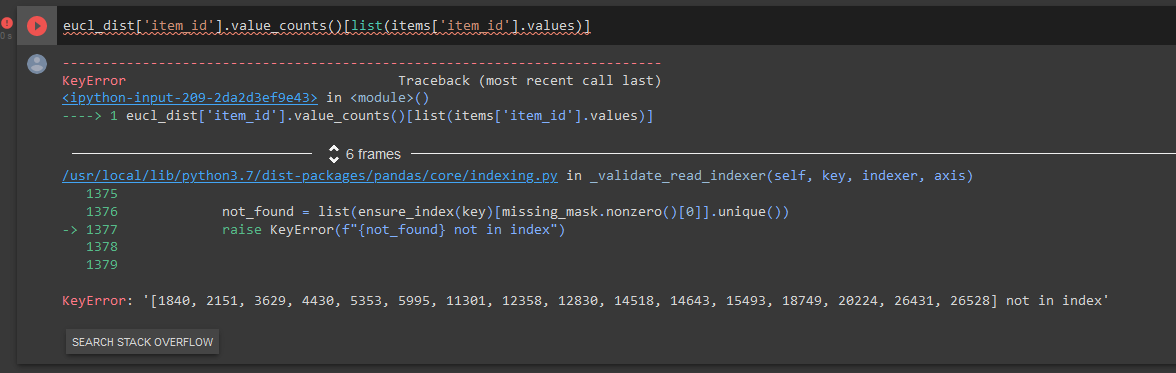

Wird geprüft wie viele der erhaltenen Items aus eucl_dist sich in dem items Datensatz befinden, erhält man 57,77986 %. Damit sind in dieser Vorherssage über die Hälfte der Vorgeschalgenen Items tatsächlich gekauft worden.

Der score betrug für eucl_dist 0.02395626959030891 -> ~ 2.4 %. 

In [ ]:
s = list(items['item_id'].values)
#the values in o are not in cosine_dist, so they get removed
o =[1840, 2151, 3629, 4430, 5353, 5995, 11301, 12358, 12830, 14518, 14643, 15493, 18749, 20224, 26431, 26528]
for i in o:
  s.remove(i)
#print the percentage of the item ids witch contained in items  
cosine_dist['item_id'].value_counts()[s].sum() / cosine_dist['item_id'].value_counts().sum()*100

Für die weitere Validierung werden aus dem train_sessions Datensatz die ersten 31578  Sessions mit der Kosinusdistanz vorhergesagt und anschließend mit der accuracy_score funktion bewertet.

Zunächst wird eine Matrix aus den ersten 150000 Einträgen des train_session Datensatzes mit den generierten Session Vektoren erstellt.

In [ ]:
cos_val = train_sessions.head(150000).drop('date', axis= 1)
cos_val

,session_id,item_id
0,3,9655
1,3,9655
2,13,15654
3,18,18316
4,18,2507
...,...,...
149995,140778,22371
149996,140778,6175
149997,140778,12242
149998,140778,11856


In [ ]:
Session_Vectors_val = cos_val.set_index('item_id').join(feature_pivtable['feature_value_id'],how='inner')

In [ ]:
# summarize all vectors from one session 
Session_Vectors_val = Session_Vectors_val.groupby('session_id').sum()
Session_Vectors_val

,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
session_id,,,,,,,,,,,,,,,,,,,,,
3,0,106,0,0,0,0,0,0,0,0,...,0,0,0,698,786,0,0,0,0,1088
13,0,0,0,618,0,766,798,0,0,0,...,0,521,0,0,351,780,0,0,219,0
18,1383,0,2379,1854,1815,0,2511,0,0,0,...,0,0,0,0,961,1534,0,0,862,1088
19,0,0,13673,10967,9279,0,7383,0,0,0,...,0,9153,0,0,7223,10360,0,0,4875,6077
24,0,53,0,2472,0,0,4483,0,0,0,...,0,1042,0,349,4265,6041,0,0,2244,2176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140768,0,0,0,2472,0,0,1576,0,0,0,...,0,521,0,0,1062,3220,0,0,300,1088
140770,0,0,0,618,0,0,394,0,0,0,...,0,0,0,0,351,885,0,0,75,544
140771,0,0,793,618,58,0,619,0,0,0,...,0,521,0,0,373,885,0,0,75,544


Anschließend wird ein Validierungsdatensatz aus dem train_purchases Datensatz erstellt

In [ ]:
test_val = train_purchases.head(31578 )
test_val = test_val.drop(['date'], axis=1)
test_val = test_val.set_index(['session_id'])
test_val

,item_id
session_id,
3,15085
13,18626
18,24911
19,12534
24,13226
...,...
140768,27332
140770,15501
140771,17925


In [ ]:
#Map function for validation
def Cosine_dist_val(x):
  q = np.array(Session_Vectors_val[Session_Vectors_val.index==x])
  q = q/np.linalg.norm(q)
  q = np.array([q[0],]*len(np.array(feature_pivtable)))
  q = pd.DataFrame(q)
  q = q.transpose()

  temp = Cos_Dist(q, w)

  temp = pd.DataFrame(temp)
  temp['item_id'] = features['item_id'].unique()
  temp = temp.set_index('item_id')

  return temp.sort_values(by=0).head(1).index

In [ ]:
%%time
l_val = map(Cosine_dist_val,list(Session_Vectors_val.index))

CPU times: user 3.97 ms, sys: 1 ms, total: 4.97 ms
Wall time: 5.03 ms


In [ ]:
%%time
import functools 
k_val = (functools.reduce(cos_reduce,l_val)) 

CPU times: user 25min 32s, sys: 26.5 s, total: 25min 58s
Wall time: 26min 4s


In [ ]:
k_val

,item_id
0,9655
1,15654
2,16299
3,20528
4,9701
...,...
31573,17541
31574,24228
31575,24467
31576,9626


In [ ]:
# generate the Dataframe for the validation
cosine_dist_val = pd.DataFrame();
cosine_dist_val['session_id'] = train_sessions.head(150000)['session_id'].unique()
cosine_dist_val['item_id'] = k_val
cosine_dist_val = cosine_dist_val.set_index('session_id')
cosine_dist_val

,item_id
session_id,
3,9655
13,15654
18,16299
19,20528
24,9701
...,...
140768,17541
140770,24228
140771,24467


Der errreichte Score beträgt hier lediglich ~ 0,26 %, das liegt aber daran, dass hier für jede Session nur ein Item vorgeschlagen wird um die accuracy_score funktion anwenden zu können.

In [ ]:
accuracy_score(test_val, cosine_dist_val)

0.0026284121856989043



---

### Kosinusdistanz nicht normiert

Zum Vergleich wird hier nocheinmal die identische Vorhersage mit der Kosinusdistanz getätigt, allerdings werden die Vektoren diesmal nicht Normiert.

In [ ]:
#generate the not normalized support matrix
w2 = np.zeros((len(np.array(feature_pivtable)),73))
ii = 0
for i in feature_pivtable.index:
  w2[ii] = feature_pivtable[feature_pivtable.index==i]['feature_value_id']
  ii = ii+1
w2 = pd.DataFrame(w2)
w2 = w2.transpose()
w2

,0,1,2,3,4,5,6,7,8,9,...,23681,23682,23683,23684,23685,23686,23687,23688,23689,23690
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,461.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0
2,0.0,889.0,793.0,0.0,793.0,793.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,793.0,793.0,0.0,889.0,0.0,0.0
3,0.0,618.0,618.0,0.0,618.0,618.0,0.0,0.0,618.0,0.0,...,618.0,0.0,618.0,618.0,618.0,618.0,0.0,719.0,0.0,0.0
4,0.0,605.0,605.0,0.0,605.0,605.0,0.0,0.0,0.0,472.0,...,0.0,0.0,0.0,0.0,605.0,605.0,0.0,605.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,885.0,592.0,538.0,592.0,592.0,805.0,639.0,805.0,805.0,592.0,...,885.0,592.0,592.0,805.0,885.0,805.0,0.0,499.0,740.0,499.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,226.0,0.0,0.0,0.0
71,75.0,75.0,75.0,75.0,75.0,649.0,75.0,75.0,75.0,219.0,...,75.0,75.0,75.0,75.0,75.0,75.0,0.0,75.0,75.0,371.0


In [ ]:
#euclidean distance nicht normiert
def Cosine_dist2(x):
  q = np.array(Session_Vectors[Session_Vectors.index==x])
  
  q = np.array([q[0],]*len(np.array(feature_pivtable)))
  q = pd.DataFrame(q)
  q = q.transpose()

  temp = Cos_Dist(q, w2)

  temp = pd.DataFrame(temp)
  temp['item_id'] = features['item_id'].unique()
  temp = temp.set_index('item_id')

  return temp.sort_values(by=0).head(100).index


In [ ]:
%%time
l2 = (map(Cosine_dist2,list(Session_Vectors.index)))

In [ ]:
%%time

import functools 

k2 = (functools.reduce(cos_reduce,l2)) 

In [ ]:
# generate the Dataframe for the leaderboard score
cos_dist2 = pd.DataFrame();
cos_dist2['session_id'] = test_leaderboard_sessions['session_id'].unique()
cos_dist2  = cos_dist2.loc[cos_dist2.index.repeat(100)].reset_index(drop=True)
cos_dist2['item_id'] = k2
cos_dist2['rank'] = cos_dist2.groupby('session_id').cumcount()+1
cos_dist2 = cos_dist2.set_index('session_id')
cos_dist2

In [ ]:
cos_dist2.to_csv('cos_dist2.csv')

#### Ergebnisanalyse

Wird geprüft wie viele der erhaltenen Items aus eucl_dist2 sich in dem items Datensatz befinden, erhält man 42,60928 %. Damit sind in dieser Vorherssage weniger als die Hälfte der Vorgeschalgenen Items tatsächlich gekauft worden.

Der score betrug für cos_dist2 0,015383501137446897  -> ~  	1,54  %. 

In [ ]:
s = list(items['item_id'].values)
#the values in o are not in eucl_dist, so they get removed
o =[2937, 3629, 5353, 5995, 8310, 11091, 11301, 12460, 13943, 14643, 20224, 22583, 25791, 26431, 26528, 27103]
for i in o:
  s.remove(i)
#print the percentage of the item ids witch contained in items 
cos_dist2['item_id'].value_counts()[s].sum() / cos_dist2['item_id'].value_counts().sum()*100

Auch hier wird der Ansatz wieder mit der accuracy_score funktion validiert.

In [ ]:
#Map function for validation
def Cosine_dist_val2(x):
  q = np.array(Session_Vectors_val[Session_Vectors_val.index==x])
  
  q = np.array([q[0],]*len(np.array(feature_pivtable)))
  q = pd.DataFrame(q)
  q = q.transpose()

  temp = Cos_Dist(q, w2)

  temp = pd.DataFrame(temp)
  temp['item_id'] = features['item_id'].unique()
  temp = temp.set_index('item_id')

  return temp.sort_values(by=0).head(1).index

In [ ]:
%%time
l_val2 = map(Cosine_dist_val2,list(Session_Vectors_val.index))

CPU times: user 7.37 ms, sys: 0 ns, total: 7.37 ms
Wall time: 12.4 ms


In [ ]:
%%time
import functools 
k_val2 = (functools.reduce(cos_reduce,l_val2)) 

CPU times: user 24min 53s, sys: 29.6 s, total: 25min 22s
Wall time: 25min 19s


In [ ]:
k_val2

,item_id
0,18256
1,15654
2,19157
3,469
4,9814
...,...
31573,2723
31574,24228
31575,24467
31576,9626


In [ ]:
# generate the Dataframe for the validation
cosine_dist_val2 = pd.DataFrame();
cosine_dist_val2['session_id'] = train_sessions.head(150000)['session_id'].unique()
cosine_dist_val2['item_id'] = k_val2
cosine_dist_val2 = cosine_dist_val2.set_index('session_id')
cosine_dist_val2

,item_id
session_id,
3,18256
13,15654
18,19157
19,469
24,9814
...,...
140768,2723
140770,24228
140771,24467


Der somit erhaltene Score ist hier mit ~ 0,17 % wie erwartet schlechter, als mit den Normierten Vektoren. Das zeigte sich auch bei dem Score, welcher von dem Wettbewerb ausgegeben wurde.


In [ ]:
accuracy_score(test_val, cosine_dist_val2)

0.0016783836848438787



---


### Kosinusdistanz normiert und mit dem Items Datensatz
In diesem Abschnitt wird ein drittes Mal die Kosinusdistanz berechnet. Hier ist der Unterschied, dass die Items der Hilfsmatrix nun aus dem Items Datensatz stammen und nicht mehr alle Items darin vorhanden sind, sondern nur noch diejenigen, welche tatsächlich gekauft wurden.

In [ ]:
w = np.zeros((len(np.array(test2)),73))
ii = 0
for i in test2.index:
  w[ii] = test2[test2.index==i]
  w[ii] = w[ii]/np.linalg.norm(w[ii])
  ii = ii+1
w = pd.DataFrame(w)
w = w.transpose()
w

,0,1,2,3,4,5,6,7,8,9,...,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989
0,0.000000,0.000000,0.000000,0.000000,0.175464,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024383,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022013,0.000000,0.000000
2,0.293068,0.263263,0.270303,0.000000,0.301828,0.281925,0.280596,0.000000,0.272549,0.000000,...,0.295533,0.000000,0.000000,0.279120,0.294761,0.284628,0.000000,0.000000,0.000000,0.000000
3,0.228394,0.205166,0.210653,0.268591,0.235221,0.219709,0.254411,0.000000,0.212403,0.267085,...,0.230315,0.289262,0.307131,0.303407,0.229713,0.221816,0.258825,0.000000,0.292594,0.284162
4,0.223589,0.200850,0.206221,0.000000,0.230273,0.215087,0.214074,0.000000,0.207935,0.000000,...,0.225470,0.000000,0.000000,0.212948,0.059473,0.217150,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.198828,0.196535,0.274394,0.257291,0.044151,0.286191,0.209474,0.000000,0.268081,0.382476,...,0.220625,0.414234,0.439824,0.249554,0.328958,0.317649,0.247936,0.000000,0.419006,0.370146
69,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
70,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
71,0.027718,0.024899,0.221219,0.032596,0.028546,0.026664,0.077491,0.000000,0.025777,0.032413,...,0.027951,0.035105,0.037273,0.026398,0.027878,0.026919,0.002932,0.000000,0.035509,0.034486


In [ ]:
%%time
l = list(map(Cosine_dist,list(Session_Vectors.index)))

CPU times: user 9min 17s, sys: 4min 48s, total: 14min 5s
Wall time: 14min 10s


In [ ]:
%%time
import functools 
k = (functools.reduce(cos_reduce,l)) 

CPU times: user 5min 19s, sys: 28.5 s, total: 5min 47s
Wall time: 5min 46s


In [ ]:
# generate the Dataframe for the leaderboard score
cos_dist3 = pd.DataFrame();
cos_dist3['session_id'] = test_leaderboard_sessions['session_id'].unique()
cos_dist3  = cos_dist3.loc[cos_dist3.index.repeat(100)].reset_index(drop=True)
cos_dist3['item_id'] = k
cos_dist3['rank'] = cos_dist3.groupby('session_id').cumcount()+1
cos_dist3 = cos_dist3.set_index('session_id')
cos_dist3

,item_id,rank
session_id,,
26,19185,1
26,16411,2
26,5199,3
26,5786,4
26,23612,5
...,...,...
4439757,19430,96
4439757,25396,97
4439757,8681,98


In [ ]:
cos_dist3.to_csv('cos_dist3.csv')

Der Score dieses Ansatzes betrug 0.030700678258728336 -> ~3,1%

Damit ist diese Vorhersage noch genauer als die beiden zuvor.

# Maschine learning Ansätze
In diesem Abschnitt werden verschiedene Maschine learning Ansätze angewendet.

## Daten präparieren
Um solche Ansätze realisieren zu können müssen zunächst die Daten entsprechend präpariert werden. Dazu wird hier die feature_pivtable (item_feature_value zuweisung zu den jeweiligen items) komprimiert, denn diese ist wie schon gesehen relativ sparse. Um auch die Größe der Matrix in Grenzen zuhalten wird die Matrix auf zehn Values pro Item komprimiert. Die hier erzeugte Matrix wird einmal mit und einmal ohne Zeitstempel erstellt um zu vergleichen ob dieser den score verbessert ooder verschlechtert. Der Aufbau der Matrix ist wie in der folgenden Tabelle dargestellt realisiert worden. Dabei wurden jeweils die ersten fünf angesehenen Items verwendet. Falls es weniger als fünf Items in einer session sind werden die restlichen Stellen mit Nullen aufgefüllt.



session_id|angesehene Items|(Zeitstempel)|Item_feature_value 1| ... | Item_feature_value 10
----------|----------------|-------------|--------------------|----|----
0 | Item 1; Item 2; Item 3; Item 4; Item 5| Zeitstempel 1; Zeitstempel 2; Zeitstempel 3; Zeitstempel 4; Zeitstempel 5|  feature_1 Item_1; feature_1 Item_2; feature_1 Item_3; feature_1 Item_4; feature_1 Item_5 |... | feature_10 Item_1; feature_10 Item_2; feature_10 Item_3; feature_10 Item_4; feature_10 Item_5
1 | Item 1; Item 2; Item 3; Item 4; Item 5| Zeitstempel 1; Zeitstempel 2; Zeitstempel 3; Zeitstempel 4; Zeitstempel 5|  feature_1 Item_1; feature_1 Item_2; feature_1 Item_3; feature_1 Item_4; feature_1 Item_5 |... | feature_10 Item_1; feature_10 Item_2; feature_10 Item_3; feature_10 Item_4; feature_10 Item_5
...|...|...|...|...|...|
...|...|...|...|...|...|
n |Item 1; Item 2; Item 3; Item 4; Item 5| Zeitstempel 1; Zeitstempel 2; Zeitstempel 3; Zeitstempel 4; Zeitstempel 5|  feature_1 Item_1; feature_1 Item_2; feature_1 Item_3; feature_1 Item_4; feature_1 Item_5 |... | feature_10 Item_1; feature_10 Item_2; feature_10 Item_3; feature_10 Item_4; feature_10 Item_5


In [ ]:
# standardizing the data points
X = StandardScaler().fit_transform(feature_pivtable)
 
# representing in CSR form
X_sparse = csr_matrix(X)

# specify the no of output features
tsvd = TruncatedSVD(n_components=10)
 
# apply the truncatedSVD function
X_sparse_tsvd = tsvd.fit(X_sparse).transform(X_sparse)
 
# shape of the reduced matrix
print('shape of the reduced matrix:',X_sparse_tsvd.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


shape of the reduced matrix: (23691, 10)


In [ ]:
#comprimized feature_pivtable
X_sparse_tsvd = pd.DataFrame(X_sparse_tsvd)
X_sparse_tsvd['item_id'] = feature_pivtable.index
X_sparse_tsvd = X_sparse_tsvd.set_index('item_id')
X_sparse_tsvd

,0,1,2,3,4,5,6,7,8,9
item_id,,,,,,,,,,
2,1.149070,3.732894,1.614947,-1.209540,-0.183640,-0.900985,0.095102,0.789540,0.954657,-2.447940
3,-2.762250,-2.729939,-1.478468,-0.002960,-1.707627,0.401353,0.324564,1.920135,-0.842729,-0.841647
4,-2.856151,-2.113452,-1.473363,0.648234,-0.460589,-0.088764,0.107134,0.766497,0.615770,-0.402038
7,-0.009180,1.090011,0.881749,-2.733677,1.503254,-0.648316,-1.934715,-0.964790,0.614073,0.412003
8,-3.278309,-3.131952,-1.492572,-0.281308,-2.523592,0.513380,0.650031,1.950083,-0.798768,-1.150831
...,...,...,...,...,...,...,...,...,...,...
28139,-3.281230,-1.509288,-2.272757,-0.891678,2.506520,-0.907368,-1.653908,-1.039419,0.906503,0.657717
28140,8.263877,-1.985099,-0.777649,0.593703,0.190847,-0.207520,0.637110,3.199113,2.977105,2.322767
28141,-2.012081,-3.275110,1.016077,-0.073637,-1.894326,0.030753,3.353940,-3.605770,3.918495,0.134030


In [ ]:
# generate the Dataset X with max five Items per session 
X = pd.merge(train_sessions, X_sparse_tsvd, left_on='item_id', right_on='item_id')
X = X.sort_values(by=['session_id','date'])
X = X.groupby('session_id').head(5)
X = X.set_index(['session_id', X.groupby('session_id').cumcount()]).unstack()
#code the timestamp to make it usable
x_date = X.date
for i in range(5):
  x_date[i] = pd.to_datetime(x_date[i]).astype(np.int64)
X.date = x_date

X = X.fillna(0)
#generate the second matrix without the timestamp
X2 = X.drop(['date'], axis=1)
X2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


item_id                                             0            \
                  0        1        2        3        4         0         1   
session_id                                                                    
3            9655.0   9655.0      0.0      0.0      0.0  8.074576  8.074576   
13          15654.0      0.0      0.0      0.0      0.0 -0.714000  0.000000   
18           4026.0   2507.0  18316.0      0.0      0.0 -2.740262 -2.884414   
19          19896.0  27937.0  12804.0  25772.0   6341.0 -3.148794 -2.315211   
24           2927.0   2927.0  16064.0  11662.0    434.0 -1.296395 -1.296395   
...             ...      ...      ...      ...      ...       ...       ...   
4439986     23502.0  13914.0  13403.0  19310.0  12373.0  0.087776  0.088625   
4439990     22093.0  17429.0   1389.0   1131.0   4062.0 -2.449933 -2.765190   
4439994     25357.0      0.0      0.0      0.0      0.0 -2.129406  0.000000   
4439999      6007.0   8502.0  13056.0   2173.0   8433.0 -3.341785 -2.232142   
4440001     25273.0  25129.0   3481.0  27400.0  25273.0  0.069784  0.071708   

                                          ...         8                      \
                   2         3         4  ...         0         1         2   
session_id                                ...                                 
3           0.000000  0.000000  0.000000  ...  0.822019  0.822019  0.000000   
13          0.000000  0.000000  0.000000  ... -1.781677  0.000000  0.000000   
18         -2.618956  0.000000  0.000000  ...  3.222936  4.313618  4.061761   
19         -2.943652 -2.827579 -2.763489  ...  1.070883  0.459528  0.440964   
24         -0.010042  1.028622 -0.100656  ... -1.288965 -1.288965  0.928261   
...              ...       ...       ...  ...       ...       ...       ...   
4439986     0.133462  0.080363  0.099304  ...  1.771060  1.793872  1.537759   
4439990    -3.103061 -3.003189 -2.384505  ...  0.888689  0.695958  0.735819   
4439994     0.000000  0.000000  0.000000  ...  0.726218  0.000000  0.000000   
4439999    -2.270226 -2.526917 -2.470896  ... -1.097984 -0.530815 -0.508152   
4440001     0.075545  0.094356  0.069784  ...  1.077757  1.240808  1.481262   

                                       9                                \
                   3         4         0         1         2         3   
session_id                                                               
3           0.000000  0.000000  0.119886  0.119886  0.000000  0.000000   
13          0.000000  0.000000  3.644415  0.000000  0.000000  0.000000   
18          0.000000  0.000000  1.326730  0.050857  0.276234  0.000000   
19          0.833646  1.216973  0.749503  0.883222  0.729941  0.633131   
24          0.001090  1.520850  0.016364  0.016364 -1.419198 -0.474017   
...              ...       ...       ...       ...       ...       ...   
4439986     1.326980  1.626317 -3.064145 -3.060789 -2.787729 -1.864370   
4439990     0.180928  0.044297  0.877348  0.727457  1.173568  0.705921   
4439994     0.000000  0.000000  0.784887  0.000000  0.000000  0.000000   
4439999     0.610039  0.050108 -0.417678  0.836853  0.748583 -0.617342   
4440001     1.532341  1.077757 -1.657152 -2.020783 -2.374691 -2.317209   

                      
                   4  
session_id            
3           0.000000  
13          0.000000  
18          0.000000  
19          0.559256  
24         -2.216157  
...              ...  
4439986    -3.035472  
4439990     0.554961  
4439994     0.000000  
4439999     0.806308  
4440001    -1.657152  

[1000000 rows x 55 columns]

In [ ]:
#generate the dataset y
y = train_purchases
y = y.set_index('session_id')
y.date = pd.to_datetime(y.date).astype(np.int64)
#generate a second dataset without the timestamp
y2 = y.drop(['date'], axis=1)
y2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  after removing the cwd from sys.path.


,item_id
session_id,
3,15085
13,18626
18,24911
19,12534
24,13226
...,...
4439986,2915
4439990,8786
4439994,21630


In [ ]:
#generate the dataset for the leaderboard prediction
X_pred = pd.merge(test_leaderboard_sessions, X_sparse_tsvd, left_on='item_id', right_on='item_id')
X_pred = X_pred.sort_values(by=['session_id','date'])
X_pred = X_pred.groupby('session_id').head(5)
X_pred = X_pred.set_index(['session_id', X_pred.groupby('session_id').cumcount()]).unstack()
#code the timestamp to make it usable
x_date = X_pred.date
for i in range(5):
  x_date[i] = pd.to_datetime(x_date[i]).astype(np.int64)
X_pred.date = x_date

X_pred = X_pred.fillna(0)
#generate a second dataset without the timestamp
X_pred2 = X_pred.drop(['date'], axis=1)
X_pred2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


item_id                                            0            \
                  0        1        2       3        4         0         1   
session_id                                                                   
26          19185.0      0.0      0.0     0.0      0.0 -2.584628  0.000000   
200         17089.0  17089.0   8060.0  4758.0      0.0  0.104617  0.104617   
205          8194.0      0.0      0.0     0.0      0.0 -3.180463  0.000000   
495          6853.0      0.0      0.0     0.0      0.0 -1.168661  0.000000   
521         26471.0      0.0      0.0     0.0      0.0 -2.741355  0.000000   
...             ...      ...      ...     ...      ...       ...       ...   
4439446     20770.0  20770.0  21396.0     0.0      0.0  0.031566  0.031566   
4439458     11715.0  26499.0      0.0     0.0      0.0 -1.193801 -3.029244   
4439550     19086.0      0.0      0.0     0.0      0.0  0.159665  0.000000   
4439653      4813.0  14075.0  14075.0  4813.0  12179.0 -2.534121 -2.516769   
4439757      2078.0   2078.0   6790.0     0.0      0.0 -2.874318 -2.874318   

                                          ...         8                      \
                   2         3         4  ...         0         1         2   
session_id                                ...                                 
26          0.000000  0.000000  0.000000  ...  0.403164  0.000000  0.000000   
200         0.052253  0.096707  0.000000  ...  1.781049  1.781049  0.858318   
205         0.000000  0.000000  0.000000  ... -1.162753  0.000000  0.000000   
495         0.000000  0.000000  0.000000  ... -0.971421  0.000000  0.000000   
521         0.000000  0.000000  0.000000  ...  0.677054  0.000000  0.000000   
...              ...       ...       ...  ...       ...       ...       ...   
4439446     0.032091  0.000000  0.000000  ...  1.317909  1.317909  1.580092   
4439458     0.000000  0.000000  0.000000  ... -1.171346 -0.497976  0.000000   
4439550     0.000000  0.000000  0.000000  ...  1.799927  0.000000  0.000000   
4439653    -2.516769 -2.534121  0.083466  ... -0.225284 -0.239197 -0.239197   
4439757    -2.762573  0.000000  0.000000  ...  0.534110  0.534110  0.637494   

                                       9                                \
                   3         4         0         1         2         3   
session_id                                                               
26          0.000000  0.000000 -0.397756  0.000000  0.000000  0.000000   
200         1.522209  0.000000 -2.936912 -2.936912 -0.731703 -2.817955   
205         0.000000  0.000000  0.095952  0.000000  0.000000  0.000000   
495         0.000000  0.000000 -0.267399  0.000000  0.000000  0.000000   
521         0.000000  0.000000  1.068072  0.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
4439446     0.000000  0.000000 -2.059822 -2.059822 -2.427225  0.000000   
4439458     0.000000  0.000000 -0.221767  0.186229  0.000000  0.000000   
4439550     0.000000  0.000000 -3.193325  0.000000  0.000000  0.000000   
4439653    -0.225284  2.275658 -1.279649 -1.145235 -1.145235 -1.279649   
4439757     0.000000  0.000000 -0.765528 -0.765528 -0.758340  0.000000   

                     
                  4  
session_id           
26          0.00000  
200         0.00000  
205         0.00000  
495         0.00000  
521         0.00000  
...             ...  
4439446     0.00000  
4439458     0.00000  
4439550     0.00000  
4439653    -4.66947  
4439757     0.00000  

[50000 rows x 55 columns]

In [ ]:
#randomly split into train and test data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.4, random_state=42)

In [ ]:
X

item_id                                                     date  \
                  0        1        2        3        4                    0   
session_id                                                                     
3            9655.0   9655.0      0.0      0.0      0.0  1608326388093000000   
13          15654.0      0.0      0.0      0.0      0.0  1584128127136000000   
18           4026.0   2507.0  18316.0      0.0      0.0  1598469347232000000   
19          19896.0  27937.0  12804.0  25772.0   6341.0  1604334636378000000   
24           2927.0   2927.0  16064.0  11662.0    434.0  1582737768903000000   
...             ...      ...      ...      ...      ...                  ...   
4439986     23502.0  13914.0  13403.0  19310.0  12373.0  1620906416606000000   
4439990     22093.0  17429.0   1389.0   1131.0   4062.0  1598096328785000000   
4439994     25357.0      0.0      0.0      0.0      0.0  1606507717262000000   
4439999      6007.0   8502.0  13056.0   2173.0   8433.0  1606474332577000000   
4440001     25273.0  25129.0   3481.0  27400.0  25273.0  1604076136855000000   

                                                                           \
                              1                    2                    3   
session_id                                                                  
3           1608326700373000000 -9223372036854775808 -9223372036854775808   
13         -9223372036854775808 -9223372036854775808 -9223372036854775808   
18          1598469391211000000  1598469510833000000 -9223372036854775808   
19          1604334648207000000  1604334665749000000  1604334678543000000   
24          1582737784840000000  1582737965585000000  1582737989178000000   
...                         ...                  ...                  ...   
4439986     1620906501792000000  1620906559975000000  1620906651523000000   
4439990     1598096360419000000  1598096399191000000  1598096449116000000   
4439994    -9223372036854775808 -9223372036854775808 -9223372036854775808   
4439999     1606474389711000000  1606474413830000000  1606474529549000000   
4440001     1604076172451000000  1604076249090000000  1604076255953000000   

                                 ...         8                                \
                              4  ...         0         1         2         3   
session_id                       ...                                           
3          -9223372036854775808  ...  0.822019  0.822019  0.000000  0.000000   
13         -9223372036854775808  ... -1.781677  0.000000  0.000000  0.000000   
18         -9223372036854775808  ...  3.222936  4.313618  4.061761  0.000000   
19          1604334873794000000  ...  1.070883  0.459528  0.440964  0.833646   
24          1582738031894000000  ... -1.288965 -1.288965  0.928261  0.001090   
...                         ...  ...       ...       ...       ...       ...   
4439986     1620906816222000000  ...  1.771060  1.793872  1.537759  1.326980   
4439990     1598096539866000000  ...  0.888689  0.695958  0.735819  0.180928   
4439994    -9223372036854775808  ...  0.726218  0.000000  0.000000  0.000000   
4439999     1606474564417000000  ... -1.097984 -0.530815 -0.508152  0.610039   
4440001     1604100295227000000  ...  1.077757  1.240808  1.481262  1.532341   

                             9                                          
                   4         0         1         2         3         4  
session_id                                                              
3           0.000000  0.119886  0.119886  0.000000  0.000000  0.000000  
13          0.000000  3.644415  0.000000  0.000000  0.000000  0.000000  
18          0.000000  1.326730  0.050857  0.276234  0.000000  0.000000  
19          1.216973  0.749503  0.883222  0.729941  0.633131  0.559256  
24          1.520850  0.016364  0.016364 -1.419198 -0.474017 -2.216157  
...              ...       ...       ...       ...       ...       ...  
4439986     1.626317 -3.064145 -3.

## Vergleich mit und ohne Zeitstempel
Hier wird zunächst der Datensatz mit und ohne Zeitstempel in einem identischen Modell (Random forest Regressor) verglichen.

### Modell mit Zeitstempel

In [ ]:
#randomly split into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
%%time
RFR =RandomForestRegressor(n_jobs=-1, n_estimators=100)
RFR.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


CPU times: user 1h 28min 48s, sys: 6.92 s, total: 1h 28min 55s
Wall time: 47min 34s


In [ ]:
#print the score of the trained modell
print(RFR.score(X_test,y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


0.4618219319477554


In [ ]:
RFR_pred = RFR.predict(X_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
RFR_pred = pd.DataFrame(RFR_pred)
RFR_pred

,0,1
0,13668.624952,1.622503e+18
1,14798.694833,1.622504e+18
2,12820.554500,1.622503e+18
3,12761.154988,1.622503e+18
4,13191.793631,1.622503e+18
...,...,...
49995,14900.222500,1.622504e+18
49996,16588.314333,1.622504e+18
49997,12161.484702,1.622503e+18
49998,17273.727667,1.622504e+18


Da die mit einem Regressor vorhergesagten Items nicht existieren, sonder dies nur Werte sind wird die Vorhersage an die am nächsten gelegenen Item id aufgerundet. Dazu werden die Ids aus dem Items Datensatz verwendet.

In [ ]:
#drop the time stamp
RFR_pred = RFR_pred.drop(1,axis=1)
RFR_pred.columns=['item_id']
#round up the prediction to the closest item id
rounding_logic = pd.Series(items['item_id'].values)
labels = rounding_logic.tolist()
rounding_logic = pd.Series([-np.inf]).append(rounding_logic)

RFR_pred['item_id'] = pd.cut(RFR_pred['item_id'], rounding_logic, labels=labels).fillna(rounding_logic.iloc[-1])
RFR_pred

,item_id
0,13669
1,14799
2,12821
3,12764
4,13205
...,...
49995,14909
49996,16598
49997,12163
49998,17276


In [ ]:
#add the session ids and a rank
RFR_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
RFR_pred['rank'] = 1
RFR_pred = RFR_pred.set_index('session_id')
RFR_pred

,item_id,rank
session_id,,
26,13669,1
200,14799,1
205,12821,1
495,12764,1
521,13205,1
...,...,...
4439446,14909,1
4439458,16598,1
4439550,12163,1


In [ ]:
RFR_pred.to_csv('RFR_pred.csv')

### Erneutes vorhersagen ohne Zeitstempel

In [ ]:
#randomly split into train and test data 
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [ ]:
%%time
#RFR = make_pipeline(StandardScaler(), RandomForestClassifier(n_jobs=-1, n_estimators=100) ) 
RFR2 = RandomForestRegressor(n_jobs=-1, n_estimators=100)
RFR2.fit(X_train2,y_train2)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 2h 4min 53s, sys: 6.95 s, total: 2h 5min
Wall time: 1h 4min 13s


In [ ]:
#print the score of the trained modell
print(RFR2.score(X_test2,y_test2))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


-0.02545284244537971


In [ ]:
RFR_pred2 = RFR2.predict(X_pred2)
RFR_pred2

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


array([17346.77974603,  9938.70935897, 18558.18865096, ...,
       13406.83538057, 17120.19      , 12904.15      ])

In [ ]:
RFR_pred2 = pd.DataFrame(RFR_pred2)
RFR_pred2.columns=['item_id']
RFR_pred2

,item_id
0,17346.779746
1,9938.709359
2,18558.188651
3,14510.651047
4,12010.590154
...,...
49995,14837.564700
49996,14833.114821
49997,13406.835381
49998,17120.190000


In [ ]:
rounding_logic = pd.Series(items['item_id'].values)
labels = rounding_logic.tolist()
rounding_logic = pd.Series([-np.inf]).append(rounding_logic) # add infinity as leftmost edge

RFR_pred2['item_id'] = pd.cut(RFR_pred2['item_id'], rounding_logic, labels=labels).fillna(rounding_logic.iloc[-1])
RFR_pred2

,item_id
0,17371
1,9941
2,18560
3,14518
4,12014
...,...
49995,14857
49996,14857
49997,13408
49998,17133


In [ ]:
RFR_pred2['session_id'] = test_leaderboard_sessions['session_id'].unique()
RFR_pred2['rank'] = 1
RFR_pred2 = RFR_pred2.set_index('session_id')
RFR_pred2

,item_id,rank
session_id,,
26,17371,1
200,9941,1
205,18560,1
495,14518,1
521,12014,1
...,...,...
4439446,14857,1
4439458,14857,1
4439550,13408,1


In [ ]:
RFR_pred2.to_csv('RFR_pred2.csv')

## Bewertung
Der angegebene accuracy score der Vorhersage mit Zeitstempel lag mit 46,18 % deutlich über dem der Vorhersage ohne Zeitstempel mit -2,545 %. Allerdings sahen die erreichten Scores auf dem leaderboard anders aus. Denn hier war die Vorhersage ohne Zeitstempel mit ~ 0,02 % besser als die Vorhersage mit Zeitstempel mit ~ 0,014 %. Aus diesem Grund wird für das weitere Vorgehen der Datensatz ohne Zeitstempel verwendet.


## Vergleich verschiedener Maschine learning Algorithmen
Da es in dem Datensatz 18907 Items gibt, würde das bei einem Classifier 18907 Klassen bedeuten. Dabei läuft aber sofort der RAM voll. Deshalb werden hier im ersten Schritt verschiedene Regressoren wie auch schon beim Vergleich mit und ohne Zeitstempel verglichen.

### MLP regressor

In [ ]:
#use MLP regressor
mlpr = make_pipeline(StandardScaler(), MLPRegressor(random_state=1, max_iter=500))

In [ ]:
%%time
mlpr.fit(X_train2,y_train2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/p

CPU times: user 40min 14s, sys: 28min 16s, total: 1h 8min 30s
Wall time: 35min 15s


In [ ]:
mlpr.score(X_test2, y_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


0.0008581822762189217

#### accuracy score
Hier werden die Vorhersagen zunächst auf den Test Datensatz getätigt um die Genauigkeit selbst zu prüfen. Dazu werden die vorhergesagten Werte auf tatsächlich existierende Item ids gerundet, um anschließend die genauigkeit mit der accuracy_score Funktion zu berechnen.

In [ ]:
#predict on the test set
MLP_pred = mlpr.predict(X_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
MLP_pred = pd.DataFrame(MLP_pred)
MLP_pred.columns=['item_id']

#round the predictet value to an item id
rounding_logic = pd.Series(features['item_id'].unique())
labels = rounding_logic.tolist()
rounding_logic = pd.Series([-np.inf]).append(rounding_logic)
MLP_pred['item_id'] = pd.cut(MLP_pred['item_id'], rounding_logic, labels=labels).fillna(rounding_logic.iloc[-1])

#add the session ids as index
MLP_pred['session_id'] = X_test2.index
MLP_pred = MLP_pred.set_index('session_id')
MLP_pred

,item_id
session_id,
4383345,14279
357505,13887
2517256,14459
2224118,13767
246261,14093
...,...
490658,13697
1886216,14025
4094052,13818


In [ ]:
accuracy_score(y_test2, MLP_pred)

5e-05

#### Vorhersage für leaderboard
Hier wird die Vorhersage auf den leaderboard Datensatz getätigt und anschließen wieder die Werte auf Item ids gerundet.


In [ ]:
#predict on the leaderboard prediction set
MLP_pred = mlpr.predict(X_pred2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
MLP_pred = pd.DataFrame(MLP_pred)
MLP_pred.columns=['item_id']

#round the predictet value to an item id
rounding_logic = pd.Series(items['item_id'].values)
labels = rounding_logic.tolist()
rounding_logic = pd.Series([-np.inf]).append(rounding_logic) # add infinity as leftmost edge
MLP_pred['item_id'] = pd.cut(MLP_pred['item_id'], rounding_logic, labels=labels).fillna(rounding_logic.iloc[-1])

#add the session ids as index and the rank
MLP_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
MLP_pred['rank'] = 1
MLP_pred = MLP_pred.set_index('session_id')
MLP_pred

,item_id,rank
session_id,,
26,12901,1
200,12508,1
205,13389,1
495,12621,1
521,13333,1
...,...,...
4439446,12621,1
4439458,14961,1
4439550,13160,1


In [ ]:
#save the predictions as csv
MLP_pred.to_csv('MLP_pred.csv')

### SVR
Hier sollte zusätzlich der SVM regressor ausgeführt und Verglichen werden, allerdings waren hier die Rechenzeiten extrem lange, womit keine Vorhersage getätigt wurde.

In [ ]:
#use SVR regressor
svm = make_pipeline(StandardScaler(), SVR() )

In [ ]:
svm.fit(X_train2,y_train2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
svm.score(X_test2, y_test2)

#### accuracy score

In [ ]:
svm_pred = regr.predict(X_test2)

In [ ]:
svm_pred = pd.DataFrame(svm_pred)
svm_pred.columns=['item_id']

rounding_logic = pd.Series(features['item_id'].unique())
labels = rounding_logic.tolist()
rounding_logic = pd.Series([-np.inf]).append(rounding_logic) # add infinity as leftmost edge

svm_pred['item_id'] = pd.cut(svm_pred['item_id'], rounding_logic, labels=labels).fillna(rounding_logic.iloc[-1])

svm_pred['session_id'] = X_test2.index
svm_pred = svm_pred.set_index('session_id')
svm_pred

In [ ]:
accuracy_score(y_test2, svm_pred)

#### Vorhersage für leaderboard

In [ ]:
svm_pred = svm.predict(X_pred2)

In [ ]:
svm_pred = pd.DataFrame(svm_pred)
svm_pred.columns=['item_id']

rounding_logic = pd.Series(items['item_id'].values)
labels = rounding_logic.tolist()
rounding_logic = pd.Series([-np.inf]).append(rounding_logic) # add infinity as leftmost edge

svm_pred['item_id'] = pd.cut(svm_pred['item_id'], rounding_logic, labels=labels).fillna(rounding_logic.iloc[-1])

svm_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
svm_pred['rank'] = 1
svm_pred = svm_pred.set_index('session_id')
svm_pred

In [ ]:
svm_pred.to_csv('svm_pred.csv')

### xgboost

In [ ]:
#use xgboost regressor
xgbr = make_pipeline(StandardScaler(),xgb.XGBRegressor(n_jobs=-1) )

In [ ]:
%%time
xgbr.fit(X_train2,y_train2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


[13:58:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 4min 11s, sys: 706 ms, total: 4min 11s
Wall time: 2min 11s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor', XGBRegressor(n_jobs=-1))])

In [ ]:
#use the score function
xgbr.score(X_test2, y_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


0.0036835602356218855

#### accuracy score
Hier werden die Vorhersagen zunächst auf den Test Datensatz getätigt um die Genauigkeit selbst zu prüfen. Dazu werden die vorhergesagten Werte auf tatsächlich existierende Item ids gerundet, um anschließend die genauigkeit mit der accuracy_score Funktion zu berechnen.

In [ ]:
xgbr_pred = xgbr.predict(X_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
xgbr_pred = pd.DataFrame(xgbr_pred)
xgbr_pred.columns=['item_id']

rounding_logic = pd.Series(features['item_id'].unique())
labels = rounding_logic.tolist()
rounding_logic = pd.Series([-np.inf]).append(rounding_logic) # add infinity as leftmost edge

xgbr_pred['item_id'] = pd.cut(xgbr_pred['item_id'], rounding_logic, labels=labels).fillna(rounding_logic.iloc[-1])

xgbr_pred['session_id'] = X_test2.index
xgbr_pred = xgbr_pred.set_index('session_id')
xgbr_pred

,item_id
session_id,
4383345,14179
357505,13931
2517256,13928
2224118,13643
246261,14221
...,...
490658,13743
1886216,13951
4094052,14398


In [ ]:
accuracy_score(y_test2, xgbr_pred)

5.75e-05

#### leaderboard score
Hier wird die Vorhersage auf den leaderboard Datensatz getätigt und anschließen wieder die Werte auf Item ids gerundet.

In [ ]:
xgbr_pred = xgbr.predict(X_pred2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
xgbr_pred = pd.DataFrame(xgbr_pred)
xgbr_pred.columns=['item_id']

rounding_logic = pd.Series(items['item_id'].values)
labels = rounding_logic.tolist()
rounding_logic = pd.Series([-np.inf]).append(rounding_logic) # add infinity as leftmost edge

xgbr_pred['item_id'] = pd.cut(xgbr_pred['item_id'], rounding_logic, labels=labels).fillna(rounding_logic.iloc[-1])

xgbr_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
xgbr_pred['rank'] = 1
xgbr_pred = xgbr_pred.set_index('session_id')
xgbr_pred

,item_id,rank
session_id,,
26,13910,1
200,13910,1
205,14054,1
495,13627,1
521,13943,1
...,...,...
4439446,13936,1
4439458,13734,1
4439550,13635,1


In [ ]:
xgbr_pred.to_csv('xgbr_pred.csv')

### Vergleich der Regressoren
Die Vorhersage mit den Regressoren bietet eine Möglichkeit Vorhersagen zutätigen ohne großen rechenaufwand. Allerdings werden hier jeweils nur eine Vorhersage getätigt, was zu keinem guten Score auf dem leaderboard führt. Dennoch lassen sich die Verschiedenen Algorithmen nach dem erreichten Score vergleichen. So wurden mit den Regressoren:

> Random Forest 0.0002 -> 0,02 %

> MLP  	0.00032 -> 0,032 %

> SVR (zu lange rechenzeiten)

> xgboost  	0.00034  -> 0,034 %

erreicht. Damit schneiden xgboost und MLP am besten ab.

## Classifier
Da die Scores mit den Regressoren nicht sehr gut ausgefallen sind werden hier die XGBoost und MLP Klassifikatoren angewendet.

Damit ein Classifier verwendet werden kann, muss die RAM-Auslastung reduziert werden. Als ersten Schritt wurde dafür nur die Sessions mit den x beliebtesten Items behalten werden.

mit 1000 beliebtesten Items ohne RAM überlauf möglich erreichter bei XGBoost Score 0.08708432010933008 -> ~8,71 %

Mit den 2500 beliebtesten Items in kombination eines lokalen Dask clients konnte ein Score von 0.09331947161463063  -> ~ 9,33 % erreicht werden.

### Daten präparieren
Hier werden die von den Datensätzen nur die jenigen Sessions behalten in denen die x beliebtesten Items gekauft wurden. Damit werden die möglichen Klassen auf ein Minimum reduziert um die RAM Auslastung gering zu halten.

In [ ]:
Items_top_2500 = train_purchases['item_id'].value_counts().head(2500).index

In [ ]:
list3 = []
for i in Items_top_2500:
  a = train_purchases[train_purchases['item_id']==i].index
  list3 = [*a, *list3]

In [ ]:
k = train_purchases.iloc[list3]['session_id']

In [ ]:
y_light = y2.loc[k]
y_light

,item_id
session_id,
144583,27206
145171,27206
308476,27206
401513,27206
543298,27206
...,...
4439015,8060
4439294,8060
4439401,8060


In [ ]:
X_light = X2.loc[k]
X_light

item_id                                             0            \
                  0        1        2        3        4         0         1   
session_id                                                                    
144583       3122.0  18425.0      0.0      0.0      0.0 -3.444908 -2.688578   
145171      14390.0  14190.0      0.0      0.0      0.0 -2.799779 -2.668135   
308476        291.0      0.0      0.0      0.0      0.0 -3.134501  0.000000   
401513       4100.0   4528.0  22881.0  18605.0  19896.0  0.260928 -2.741647   
543298      27990.0  28091.0      0.0      0.0      0.0 -1.487172 -2.856864   
...             ...      ...      ...      ...      ...       ...       ...   
4439015     18156.0      0.0      0.0      0.0      0.0  0.394769  0.000000   
4439294     27151.0  27151.0      0.0      0.0      0.0  0.122160  0.122160   
4439401     26531.0      0.0      0.0      0.0      0.0 -0.438749  0.000000   
4439629     19317.0  18065.0  11925.0      0.0      0.0  0.168355  0.168149   
4439936     23764.0      0.0      0.0      0.0      0.0  0.104617  0.000000   

                                          ...         8                      \
                   2         3         4  ...         0         1         2   
session_id                                ...                                 
144583      0.000000  0.000000  0.000000  ...  3.628807  4.374621  0.000000   
145171      0.000000  0.000000  0.000000  ...  4.058116  4.355225  0.000000   
308476      0.000000  0.000000  0.000000  ...  3.780965  0.000000  0.000000   
401513      0.042241 -3.228713 -3.148794  ...  2.430358  0.860946  1.463383   
543298      0.000000  0.000000  0.000000  ... -1.703196  4.400278  0.000000   
...              ...       ...       ...  ...       ...       ...       ...   
4439015     0.000000  0.000000  0.000000  ...  1.809552  0.000000  0.000000   
4439294     0.000000  0.000000  0.000000  ...  1.433231  1.433231  0.000000   
4439401     0.000000  0.000000  0.000000  ... -1.253154  0.000000  0.000000   
4439629     0.150767  0.000000  0.000000  ...  1.677899  2.450387  2.261763   
4439936     0.000000  0.000000  0.000000  ...  1.785819  0.000000  0.000000   

                                       9                                \
                   3         4         0         1         2         3   
session_id                                                               
144583      0.000000  0.000000  0.844445 -0.116652  0.000000  0.000000   
145171      0.000000  0.000000  0.142559  0.052584  0.000000  0.000000   
308476      0.000000  0.000000  0.761662  0.000000  0.000000  0.000000   
401513      3.817887  1.068665 -4.726725  0.700608 -2.410724  0.687587   
543298      0.000000  0.000000  0.584955 -0.046513  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
4439015     0.000000  0.000000 -2.747520  0.000000  0.000000  0.000000   
4439294     0.000000  0.000000 -2.282123 -2.282123  0.000000  0.000000   
4439401     0.000000  0.000000  3.395415  0.000000  0.000000  0.000000   
4439629     0.000000  0.000000 -2.919701 -4.215349 -4.327232  0.000000   
4439936     0.000000  0.000000 -2.929525  0.000000  0.000000  0.000000   

                      
                   4  
session_id            
144583      0.000000  
145171      0.000000  
308476      0.000000  
401513      0.751762  
543298      0.000000  
...              ...  
4439015     0.000000  
4439294     0.000000  
4439401     0.000000  
4439629     0.000000  
4439936     0.000000  

[758659 rows x 55 columns]

In [ ]:
#randomly split into train and test data
from sklearn.model_selection import train_test_split
X_train_light, X_test_light, y_train_light, y_test_light = train_test_split(X_light, y_light, test_size=0.4, random_state=42)

### XGBoost
Die Vorhersagen mit XGBoost wurden mit der tree_method="gpu_hist" getätigt. Dabei wird die GPU als Hardwarebeschleuniger verwendet was für deutlich kürzere Rechenzeiten sorgte. Außerdem ist es mit den top 2500 Items nicht möglich die Vorhersage ohne tree_method="gpu_hist" zu treffen, da sonst der RAM vollläuft.

In [ ]:
#use XGBoost
xgbc = xgb.XGBClassifier(n_jobs=-1,max_depth =6,n_estimators=50,tree_method="gpu_hist")

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.77 GB -- Worker memory limit: 11.00 GB


#### Direktes Berechnen
!Funktionier nur mit dem top 1000 Items Datensatz!

In [ ]:
%%time
xgbc.fit(X_train_light,y_train_light)

NameError: ignored

#### Dask client

In [ ]:
client = Client(processes=False,
                memory_target_fraction=0.95,
                 memory_limit='11GB')             # create local client

client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.28.0.2:8787/status,
Dashboard: http://172.28.0.2:8787/status,Workers: 1
Total threads: 2,Total memory: 10.24 GiB
Status: running,Using processes: False
Comm: inproc://172.28.0.2/1819/1,Workers: 1
Dashboard: http://172.28.0.2:8787/status,Total threads: 2
Started: Just now,Total memory: 10.24 GiB
Comm: inproc://172.28.0.2/1819/4,Total threads: 2
Dashboard: http://172.28.0.2:36325/status,Memory: 10.24 GiB
Nanny: None,


In [ ]:
%%time
with joblib.parallel_backend('dask'):
    # Your scikit-learn code
    xgbc.fit(X_train_light,y_train_light)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.80 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.80 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.80 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.80 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Proces

In [ ]:
xgbc.save_model('xgb_classifier.json')

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.33 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.31 GB -- Worker memory limit: 11.00 GB


#### 100 beste Vorschläge
Damit die Möglichen 100 Vorschläge für den Wettbewerb ausgnutzt werden können wird die Funktion Predict_Proba verwendet und dabei die 100 wahrscheinlichsten Klassen(Items) verwendet.

In [ ]:
#print the classes
xgbc.classes_

array([   93,   107,   112,   123,   295,   305,   412,   434,   551,
         563,   594,   647,   702,   705,   742,   773,   878,   930,
         955,   972,  1011,  1018,  1048,  1065,  1085,  1122,  1148,
        1206,  1272,  1273,  1367,  1368,  1374,  1474,  1531,  1597,
        1637,  1640,  1644,  1730,  1780,  1783,  1808,  1818,  1899,
        1992,  1998,  2072,  2098,  2100,  2101,  2173,  2188,  2200,
        2366,  2410,  2447,  2499,  2616,  2646,  2752,  2814,  2845,
        2915,  2972,  3026,  3099,  3106,  3117,  3126,  3233,  3237,
        3327,  3338,  3373,  3393,  3423,  3591,  3683,  3697,  3705,
        3740,  3741,  3774,  3815,  3825,  3859,  3878,  4028,  4064,
        4125,  4130,  4193,  4235,  4400,  4425,  4428,  4590,  4612,
        4635,  4822,  4917,  4935,  5056,  5066,  5070,  5075,  5096,
        5199,  5288,  5299,  5365,  5433,  5508,  5583,  5620,  5642,
        5672,  5704,  5850,  5880,  5920,  5932,  5963,  6071,  6145,
        6181,  6187,

In [ ]:
#use predict_proba for the Prediction and set the colums to the Class (Item Id)
s = pd.DataFrame(xgbc.predict_proba(X_pred2))
s.columns=xgbc.classes_
s

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 10.70 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.01 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.01 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.01 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.01 GB -- Worker memory limit: 11.00 GB
distributed.wor

,26,33,64,93,101,107,112,115,123,167,...,28051,28055,28057,28063,28065,28091,28101,28114,28124,28133
0,0.000150,0.000648,0.000143,0.000312,0.000165,0.003071,0.000186,0.000146,0.000494,0.000193,...,0.000274,0.001972,0.000117,0.000492,0.000159,0.000262,0.000186,0.000175,0.000288,0.000294
1,0.000056,0.000055,0.000051,0.000250,0.000053,0.000088,0.000092,0.000046,0.000086,0.000068,...,0.000180,0.000054,0.000042,0.000045,0.000054,0.000073,0.000077,0.000062,0.000050,0.000311
2,0.000152,0.000643,0.000144,0.000315,0.000502,0.001135,0.000861,0.000191,0.000746,0.000234,...,0.000234,0.000571,0.000118,0.000621,0.000182,0.000180,0.000188,0.000626,0.000295,0.000297
3,0.000173,0.000451,0.000254,0.000249,0.000273,0.000864,0.000246,0.000169,0.001094,0.000275,...,0.000178,0.000398,0.000135,0.000334,0.000688,0.000205,0.000215,0.000326,0.000397,0.000310
4,0.000128,0.000677,0.000384,0.000143,0.000216,0.000665,0.000159,0.000380,0.000915,0.010076,...,0.000132,0.000210,0.000100,0.000870,0.000272,0.000134,0.000167,0.000150,0.001980,0.000185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.000104,0.000104,0.000101,0.000123,0.000124,0.000156,0.000132,0.000091,0.000184,0.000135,...,0.000130,0.000107,0.000839,0.000090,0.000110,0.000111,0.000134,0.000124,0.000099,0.000357
49996,0.000157,0.000256,0.000197,0.000278,0.000266,0.000727,0.000224,0.000134,0.001015,0.000299,...,0.000162,0.000434,0.000122,0.001005,0.000607,0.000166,0.000208,0.000203,0.000420,0.000281
49997,0.000149,0.000144,0.000142,0.000779,0.000148,0.000304,0.000197,0.000128,0.000498,0.000194,...,0.000146,0.000151,0.000116,0.000126,0.000151,0.000157,0.000192,0.000175,0.000140,0.001488
49998,0.000069,0.000136,0.000166,0.000172,0.000110,0.000380,0.000087,0.000060,0.000181,0.000123,...,0.000110,0.000223,0.000055,0.000116,0.000116,0.000110,0.000144,0.000108,0.000076,0.000217


distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB


Um für jede Sessionvorhersage die 100 wahrscheinlichten Items zu wählen werden diese aus der Matrix s mit einer Map reduce Funktion sortiert und hereaus geschrieben. Dabei werden sie in der Map Funktion sortiert und in der reduce Funktion in einem Dataframe zusammengefasst.

In [ ]:
#Map function
def Map_sort(x):

  return s[s.index==x].transpose().sort_values(by=[x],ascending=False).head(100).index

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB


In [ ]:
#reduce function
def Reduce_concat(a,b):
  return pd.concat([pd.DataFrame(a),pd.DataFrame(b)], ignore_index=True)

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB


In [ ]:
%%time
l = map(Map_sort,list(s.index))

CPU times: user 2.6 ms, sys: 0 ns, total: 2.6 ms
Wall time: 2.59 ms


distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB


In [ ]:
%%time
import functools 
k = (functools.reduce(Reduce_concat,l)) 

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.38 GB -- Worker memory limit: 11.00 GB
distributed.wor

CPU times: user 5min 48s, sys: 18.8 s, total: 6min 7s
Wall time: 5min 48s


In [ ]:
k

,0
0,8861
1,17740
2,23612
3,26853
4,5199
...,...
4999995,17780
4999996,20962
4999997,26
4999998,15458


In [ ]:
# generate the Dataframe for the leaderboard score
xgb_pred = pd.DataFrame();
xgb_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
xgb_pred  = xgb_pred.loc[xgb_pred.index.repeat(100)].reset_index(drop=True)
xgb_pred['item_id'] = k
xgb_pred['rank'] = xgb_pred.groupby('session_id').cumcount()+1
xgb_pred = xgb_pred.set_index('session_id')
xgb_pred

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.32 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.41 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.45 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.46 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.46 GB -- Worker memory limit: 11.00 GB
distributed.wor

,item_id,rank
session_id,,
26,8861,1
26,17740,2
26,23612,3
26,26853,4
26,5199,5
...,...,...
4439757,17780,96
4439757,20962,97
4439757,26,98


distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.73 GB -- Worker memory limit: 11.00 GB


In [ ]:
#save the prediction as csv
xgb_pred.to_csv('xgb_pred.csv')

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.74 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.74 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.74 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.74 GB -- Worker memory limit: 11.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 11.74 GB -- Worker memory limit: 11.00 GB
distributed.wor

#### Analyse

In [ ]:
pred_xgbc = xgbc.predict(X_test_light)

In [ ]:
pred_xgbc = pd.DataFrame(pred_xgbc)
pred_xgbc.columns=['item_id']


pred_xgbc['session_id'] = X_test_light.index
pred_xgbc = pred_xgbc.set_index('session_id')
pred_xgbc

In [ ]:
accuracy_score(y_test_light, pred_xgbc)

### MLPC

In [ ]:
MLPC = make_pipeline(StandardScaler(), MLPClassifier(random_state=1) )

In [ ]:
MLPC.fit(X_train_light,y_train_light)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
%%time
with joblib.parallel_backend('dask'):
    # Your scikit-learn code
    MLPC.fit(X_train_light,y_train_light)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
distributed.worker - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 8.22 GiB -- Worker memory limit: 10.24 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may 

In [ ]:
s = pd.DataFrame(MLPC.predict_proba(X_pred2))
s.columns=MLPC.classes_
s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


,26,33,64,93,101,107,112,115,123,167,...,28051,28055,28057,28063,28065,28091,28101,28114,28124,28133
0,3.284362e-04,2.586777e-04,0.000139,0.000210,2.663261e-05,0.003625,0.000072,4.786530e-06,2.256745e-05,7.573895e-05,...,0.000144,4.066184e-03,2.475716e-05,3.421604e-04,7.204671e-05,0.000138,0.000166,3.882936e-05,1.129929e-04,0.000254
1,1.038636e-06,1.165023e-05,0.000008,0.000086,5.858556e-08,0.000002,0.000001,6.751442e-08,7.923524e-07,5.504870e-06,...,0.000035,3.524503e-06,2.430840e-04,2.871513e-07,1.536305e-05,0.000028,0.000091,8.071792e-07,2.977310e-07,0.000567
2,4.529955e-05,3.437200e-04,0.000024,0.000605,1.505392e-04,0.003863,0.000166,5.049073e-05,2.276511e-04,4.790285e-05,...,0.000026,1.437228e-03,3.948983e-05,7.894201e-04,2.900261e-05,0.000038,0.000222,2.381605e-04,2.689561e-04,0.000538
3,1.001042e-05,2.453426e-04,0.000207,0.000310,4.612320e-06,0.000679,0.000514,3.494947e-05,8.121034e-04,2.116996e-04,...,0.000194,4.007419e-04,2.618868e-05,3.273693e-04,1.263280e-03,0.000079,0.000083,2.104294e-04,5.814786e-04,0.000248
4,7.648075e-05,7.107174e-04,0.002718,0.000048,1.083986e-04,0.000654,0.000074,5.092474e-05,6.186962e-04,2.410994e-03,...,0.000015,1.935900e-04,8.351866e-06,1.672759e-03,2.869633e-04,0.000058,0.000048,2.533033e-05,2.043443e-03,0.000050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2.197872e-06,3.607846e-07,0.000002,0.000009,1.650184e-05,0.000002,0.000163,1.047757e-05,3.454266e-04,8.285119e-07,...,0.000012,2.425654e-08,9.020832e-04,2.448738e-07,1.385714e-07,0.000001,0.000003,3.273761e-05,5.602349e-05,0.000321
49996,1.391144e-05,2.007324e-04,0.000043,0.000089,4.993156e-05,0.000873,0.000317,8.137620e-06,4.880093e-04,3.065018e-04,...,0.000048,1.926878e-03,3.395560e-05,5.762220e-04,5.369493e-04,0.000099,0.000206,1.145332e-04,7.143887e-04,0.000054
49997,1.287828e-05,2.191255e-05,0.000142,0.001593,3.621695e-06,0.000207,0.000009,1.241814e-07,2.901316e-05,1.329059e-04,...,0.000013,7.652825e-05,1.918422e-04,1.137355e-06,6.527267e-06,0.000034,0.000534,1.010039e-05,8.013615e-07,0.002798
49998,1.768937e-08,1.044321e-03,0.000006,0.007042,1.008478e-05,0.001048,0.000001,5.362892e-07,2.317470e-06,7.421777e-05,...,0.000005,3.425235e-04,2.779485e-07,1.078153e-05,1.749191e-05,0.000015,0.002308,6.639813e-05,1.450731e-07,0.000256


In [ ]:
#Map function
def Map_sort(x):

  return s[s.index==x].transpose().sort_values(by=[x],ascending=False).head(100).index

In [ ]:
#reduce function
def Reduce_concat(a,b):
  return pd.concat([pd.DataFrame(a),pd.DataFrame(b)], ignore_index=True)

In [ ]:
%%time
l = map(Map_sort,list(s.index))

CPU times: user 2.28 ms, sys: 1.01 ms, total: 3.28 ms
Wall time: 3.22 ms


In [ ]:
%%time
import functools 
k = (functools.reduce(Reduce_concat,l)) 

CPU times: user 6min 55s, sys: 11.4 s, total: 7min 7s
Wall time: 7min 16s


In [ ]:
# generate the Dataframe for the leaderboard score
MLPC_pred = pd.DataFrame();
MLPC_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
MLPC_pred  = MLPC_pred.loc[MLPC_pred.index.repeat(100)].reset_index(drop=True)
MLPC_pred['item_id'] = k
MLPC_pred['rank'] = MLPC_pred.groupby('session_id').cumcount()+1
MLPC_pred = MLPC_pred.set_index('session_id')
MLPC_pred

,item_id,rank
session_id,,
26,26853,1
26,15533,2
26,23612,3
26,4193,4
26,17740,5
...,...,...
4439757,10454,96
4439757,5818,97
4439757,8623,98


In [ ]:
MLPC_pred.to_csv('MLPC_pred.csv')

In [ ]:
MLPC.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'mlpclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'mlpclassifier__activation', 'mlpclassifier__alpha', 'mlpclassifier__batch_size', 'mlpclassifier__beta_1', 'mlpclassifier__beta_2', 'mlpclassifier__early_stopping', 'mlpclassifier__epsilon', 'mlpclassifier__hidden_layer_sizes', 'mlpclassifier__learning_rate', 'mlpclassifier__learning_rate_init', 'mlpclassifier__max_fun', 'mlpclassifier__max_iter', 'mlpclassifier__momentum', 'mlpclassifier__n_iter_no_change', 'mlpclassifier__nesterovs_momentum', 'mlpclassifier__power_t', 'mlpclassifier__random_state', 'mlpclassifier__shuffle', 'mlpclassifier__solver', 'mlpclassifier__tol', 'mlpclassifier__validation_fraction', 'mlpclassifier__verbose', 'mlpclassifier__warm_start'])

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False,
                memory_target_fraction=0.95,
                 memory_limit='11GB')
client = Client(cluster)



In [ ]:
#get client info
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.28.0.2:8787/status,
Dashboard: http://172.28.0.2:8787/status,Workers: 1
Total threads: 2,Total memory: 10.24 GiB
Status: running,Using processes: False
Comm: inproc://172.28.0.2/1592/1,Workers: 1
Dashboard: http://172.28.0.2:8787/status,Total threads: 2
Started: Just now,Total memory: 10.24 GiB
Comm: inproc://172.28.0.2/1592/4,Total threads: 2
Dashboard: http://172.28.0.2:32865/status,Memory: 10.24 GiB
Nanny: None,


In [ ]:
!npm install -g localtunnel



/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
added 22 packages from 22 contributors in 2.893s


In [ ]:
!lt --port 8787

your url is: https://few-jars-care-35-196-89-7.loca.lt
1+1
^C


# Neuer Abschnitt

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import TensorBoard

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(pd.DataFrame(normalize(feature_pivtable)), pd.DataFrame(normalize(feature_pivtable)), test_size=0.2, random_state=42)

NameError: ignored

In [ ]:
y_train2.shape

In [ ]:
# Let's say we expect our inputs to be RGB images of arbitrary size
inputs = keras.Input(shape=(73, ))

# Add a dense classifier on top
encoded1  = layers.Dense( 40, activation="relu")(inputs)
encoded2  = layers.Dense( 30, activation="relu")(encoded1)
encoded3  = layers.Dense( 15, activation="relu")(encoded2)

decoded0  = layers.Dense( 35, activation="relu")(encoded3)
decoded  = layers.Dense( 73, activation="softmax")(decoded0)

In [ ]:
autoencoder = keras.Model(inputs, decoded )

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
autoencoder.summary()

In [ ]:
history = autoencoder.fit(X_train2, X_train2,
epochs=100,
batch_size=1000,
shuffle=True,validation_data=(y_test2, y_test2 ))


In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'])

# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'])


In [ ]:
comprimized['index'] = y_test2.index
comprimized = comprimized.set_index('index')
comprimized

NameError: ignored

In [ ]:
Z = autoencoder(feature_pivtable.to_numpy())

In [ ]:
z = pd.DataFrame(Z.numpy())
z

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
z[z.index==2].values.sum()

1.0